# Выбор локации для скважины

Компании «ГлавРосГосНефть» нужно помочь с решением, где бурить новую скважину. В избранном регионе собирают информацию о качестве нефти и объёме её запасов для каждой скважины. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски.


### План выполнения

1. [Загрузка данных](#task_1) <a id='task_1_plan'></a>
    - Пропущенные значения
    - Неправильные типы данных
    - Неправильные значения категорий

2. [Предобработка данных](#task_2) <a id='task_2_plan'></a>
    - Поиск дубликатов

3. [Исследовательский анализ данных](#task_3) <a id='task_3_plan'></a>
    - Распределение признаков
    - Поиск выбросов и аномалий
    - Что влияет на большой и малый объём запасов в скважине?
    - Корреляционный анализ

4. [Подготовка данных и обучение моделей](#task_4) <a id='task_4_plan'></a>
    - Пайплайн для подготовки данных
    - Обучение моделей для каждого региона
    - Анализ остатков
    - Анализ важности признаков

5. [Расчет прибыли](#task_5) <a id='task_5_plan'></a>
    - Достаточный объём сырья для безубыточной разработки новой скважины
    - Расчёт прибыли по выбранным скважинам
    - Риски и прибыль для каждого региона

6. [Вывод работы](#result) <a id='result_plan'></a>

### Описание данных

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек
- `product` — объём запасов в скважине (тыс. баррелей).

Каждая таблица соответствует своему региону.

In [62]:
!pip install -r requirements.txt

### [Загрузка данных](#task_1_plan) <a id='task_1'></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import phik

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.signal import argrelextrema

RANDOM_STATE=22

In [2]:
# Информация о таблице, наличие пропусков 
def get_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    display(df.head())
    df.info()
    display((df.isna().mean() * 100).sort_values(ascending=False).to_frame(name='пропуски_в_%'))
    return df

In [3]:
# Проверка наличия директории 
def check_dataset(path0, path1, sep):
    if os.path.exists(path0):
        return get_dataset(path0, sep)
    elif os.path.exists(path1):
        return get_dataset(path0, sep)
    else:
        print('неправильный путь к файлу')

In [4]:
path0 = './datasets/geo_data_0.csv'
path1 = '/datasets/geo_data_0.csv'

geo_data_0 = check_dataset(path0, path1, sep=',')

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,пропуски_в_%
id,0.0
f0,0.0
f1,0.0
f2,0.0
product,0.0


Датасет состоит из 100.000 наблюдений. Пропуски и неправильные типы данных отсутствуют.

In [5]:
path0 = './datasets/geo_data_1.csv'
path1 = '/datasets/geo_data_1.csv'

geo_data_1 = check_dataset(path0, path1, sep=',')

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,пропуски_в_%
id,0.0
f0,0.0
f1,0.0
f2,0.0
product,0.0


In [6]:
path0 = './datasets/geo_data_2.csv'
path1 = '/datasets/geo_data_2.csv'

geo_data_2 = check_dataset(path0, path1, sep=',')

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,пропуски_в_%
id,0.0
f0,0.0
f1,0.0
f2,0.0
product,0.0


#### Вывод загрузки данных

Все датасеты не имеют пропусков, неправильных типов данных.

### [Предобработка данных](#task_2_plan) <a id='task_2'></a>

In [7]:
print('Количество неявных дубликатов')
print('geo_data_0:', geo_data_0.duplicated(subset=['f0', 'f1', 'f2']).sum())
print('geo_data_1:', geo_data_1.duplicated(subset=['f0', 'f1', 'f2']).sum())
print('geo_data_2:', geo_data_2.duplicated(subset=['f0', 'f1', 'f2']).sum())

Количество неявных дубликатов
geo_data_0: 0
geo_data_1: 0
geo_data_2: 0


#### Вывод предобработки данных

Датасеты были проверены на дубликаты по входным признакам. В случае дубликатов, линейная модель может переобучиться на повторяющихся данных и иметь неверные коэффициенты.

### [Исследовательский анализ](#task_3_plan) <a id='task_3'></a>

#### Распределение признаков

In [8]:
def plt_distribution(df):
    plt.figure(figsize=(22, 10))
    cols = df.select_dtypes(include='number').columns
    df = df[cols].copy()

    for i, clm in enumerate(cols):
        plt.subplot(2, 2, i+1)
        if df[clm].nunique() >= 20:
            ax = sns.histplot(data=df, x=clm, stat="density")
            sns.kdeplot(data=df, x=clm, bw_method=0.07, color="red")
        else:
            df[f'rounded_{clm}'] = round(df[clm], 2)
            ax = sns.countplot(data=df, x=f'rounded_{clm}', color='#1F77B4') 
        ax.set_ylabel('частота')

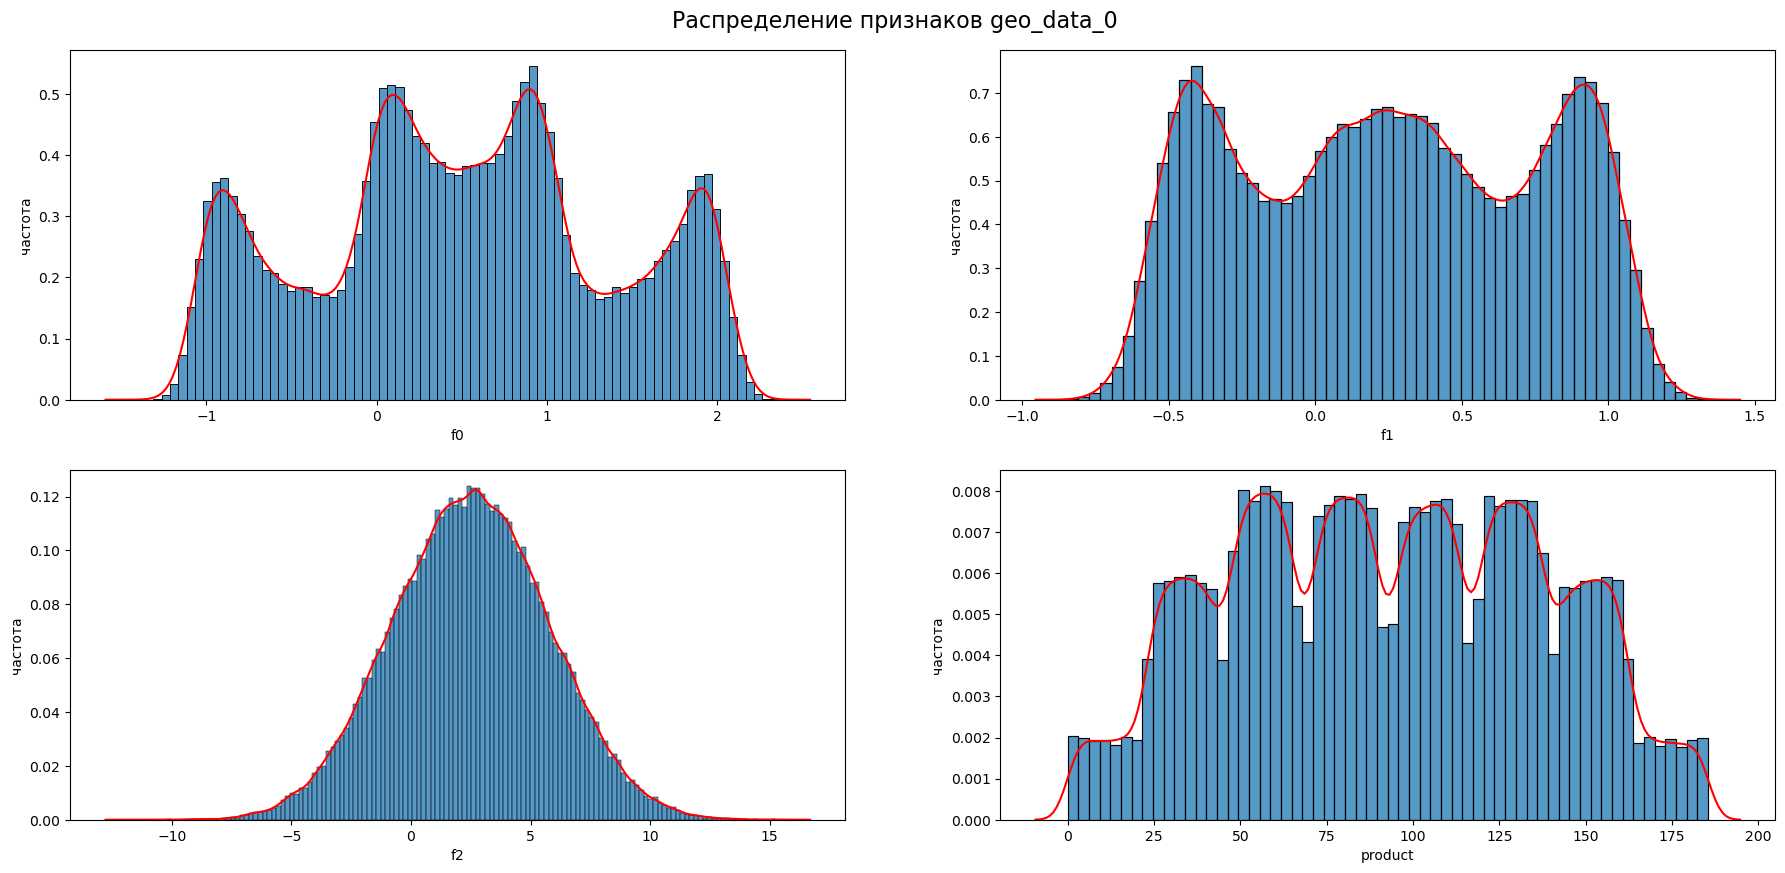

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
plt_distribution(geo_data_0)
plt.suptitle('Распределение признаков geo_data_0', fontsize=16, y=0.92)
plt.show()

geo_data_0.describe()

По распределениям признаков видно, что данные сильно синтетические. Каждый из признаков имеент уникальное распределение:
1. `f0`: мультимодальное распределение с 4-мя вершинами
2. `f1`: мультимодальное распределение с 3-мя вершинами
3. `f2`: нормальное распределение
4. `product`: необычное распределение с множеством равномерных впадин и пиков

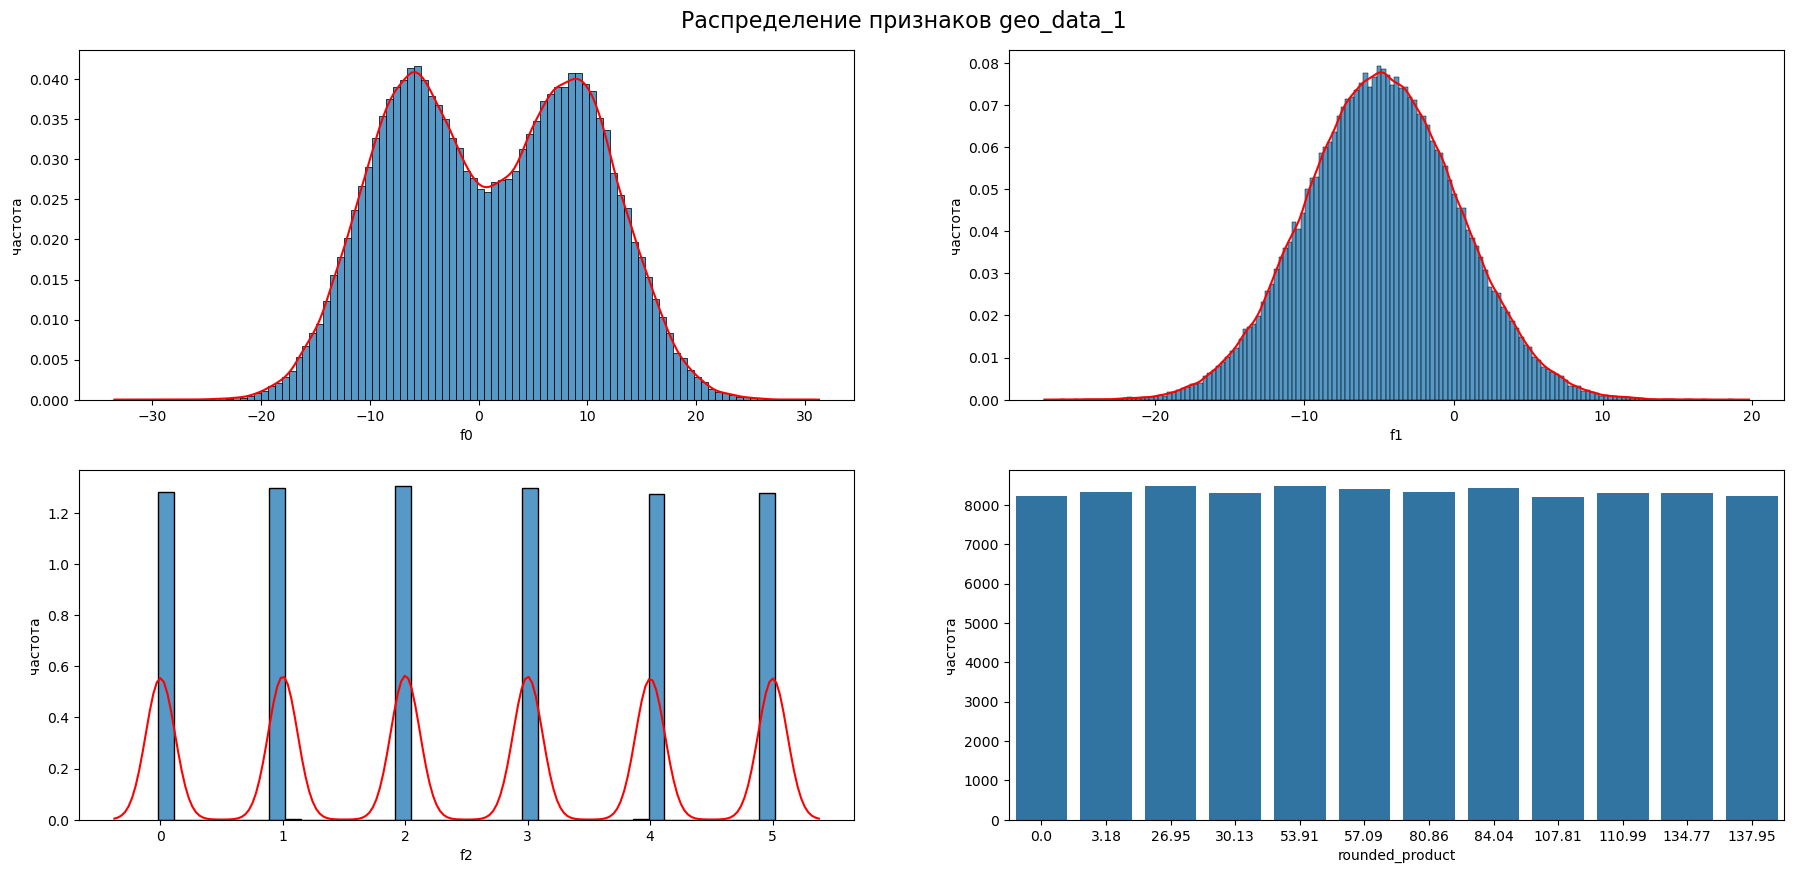

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
plt_distribution(geo_data_1)
plt.suptitle('Распределение признаков geo_data_1', fontsize=16, y=0.92)
plt.show()

geo_data_1.describe()

1. `f0`: бимодальное распределением
2. `f1`: нормальное распределение
3. `f2`: шумный признак, значения кучкуются у целых в равных пропорциях. 
4. `product`: 12 уникальных значений, распределенных равномерно.

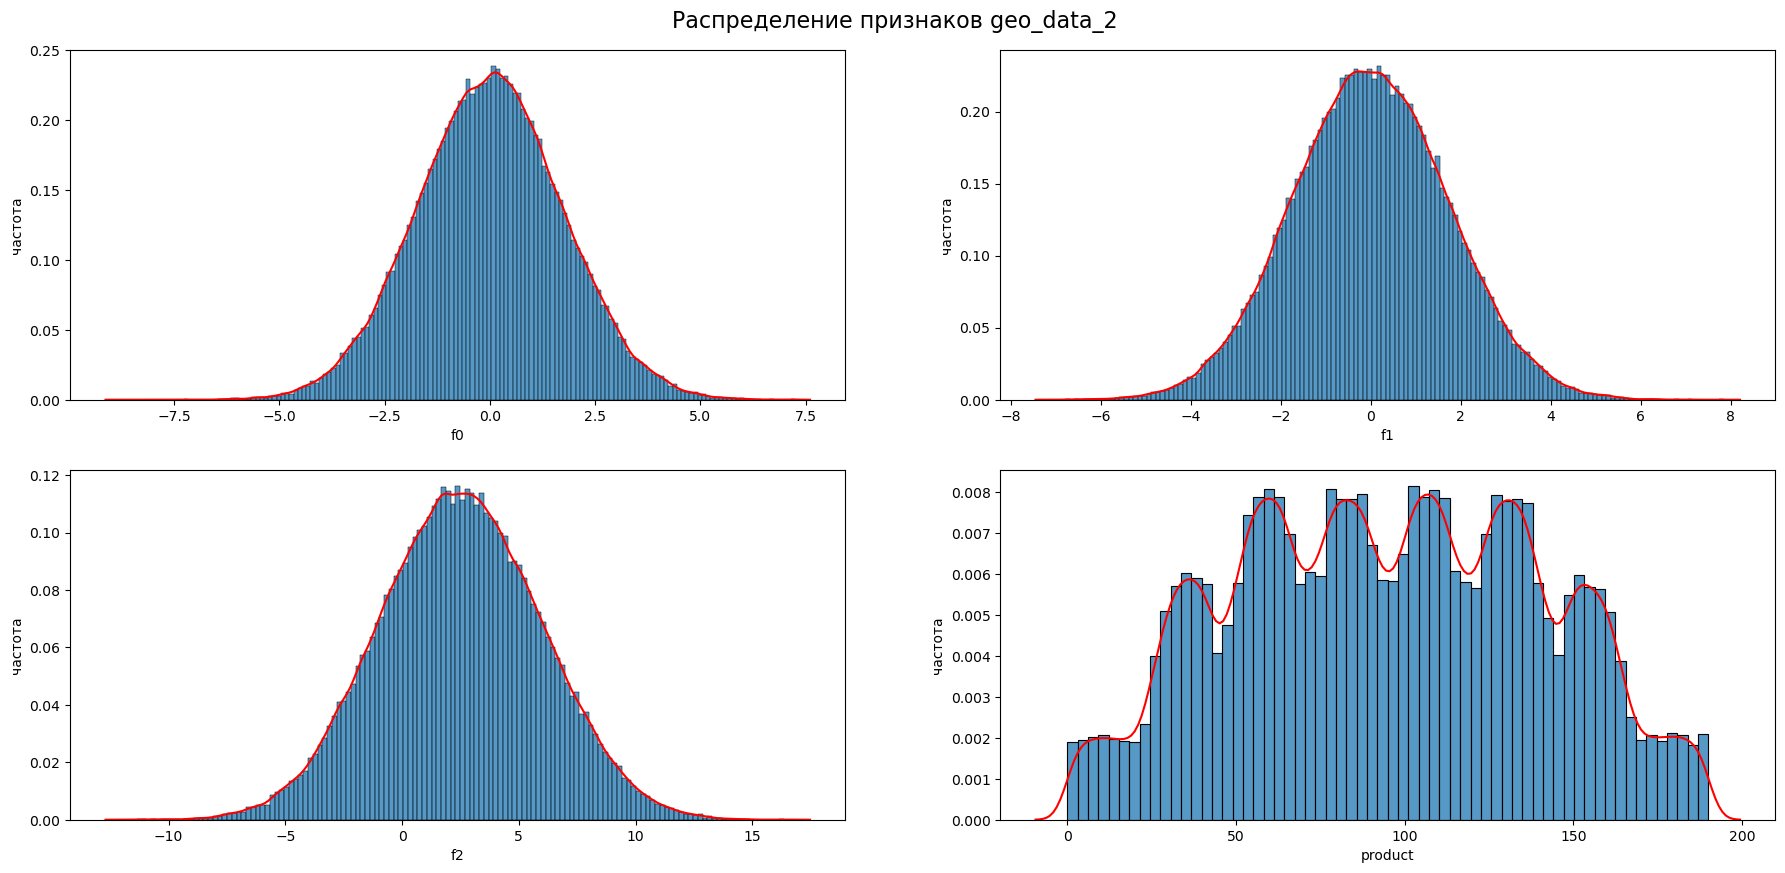

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [11]:
plt_distribution(geo_data_2)
plt.suptitle('Распределение признаков geo_data_2', fontsize=16, y=0.92)
plt.show()

geo_data_2.describe()

1. `f0`: нормальное распределение
2. `f1`: нормальное распределение
3. `f2`: нормальное распределение
4. `product`: схоже с распределением из geo_data_0

**Промежуточный вывод:**

В каждом из датасетов данные являются синтетическими. \
В регионе **`geo_data_1`** количество запасов в скважине имеет равномерное распределение, признак состоит из 12 уникальных категорий и наибольшее значение - 138 тыс. баррелей, что меньше по сравнению с двумя другими регионами. В данном регионе признак точек `f2` можно округлить и перевести в категориальный. 

#### Выбросы и аномалии

In [12]:
# Функция для отрисовки диаграммы размаха количественных признаков
def plt_boxplot_scaler(df):
    plt.figure(figsize=(12, 6))
    scaled = MinMaxScaler()
    
    num_columns = [clm for clm in df.select_dtypes(include='number').columns.tolist() if df[clm].nunique() >= 20]
    sns.boxplot(data=pd.DataFrame(data=scaled.fit_transform(df[num_columns]), columns=num_columns), orient='v')


In [13]:
# Функция для избавления от выбросов в количественных признаках
def get_emission_free(df):
    cols = [clm for clm in df.select_dtypes(include='number').columns.tolist() if df[clm].nunique() >= 20]
    for clm in cols:
        IQR = df[clm].quantile(0.75) - df[clm].quantile(0.25)
        minimum = df[clm].quantile(0.25) - 1.5 * IQR
        maximum = df[clm].quantile(0.75) + 1.5 * IQR
        df.query(f'({clm} >= @minimum) and ({clm} <= @maximum)', inplace=True)
        df.reset_index(drop=True, inplace=True)
    plt_boxplot_scaler(df)

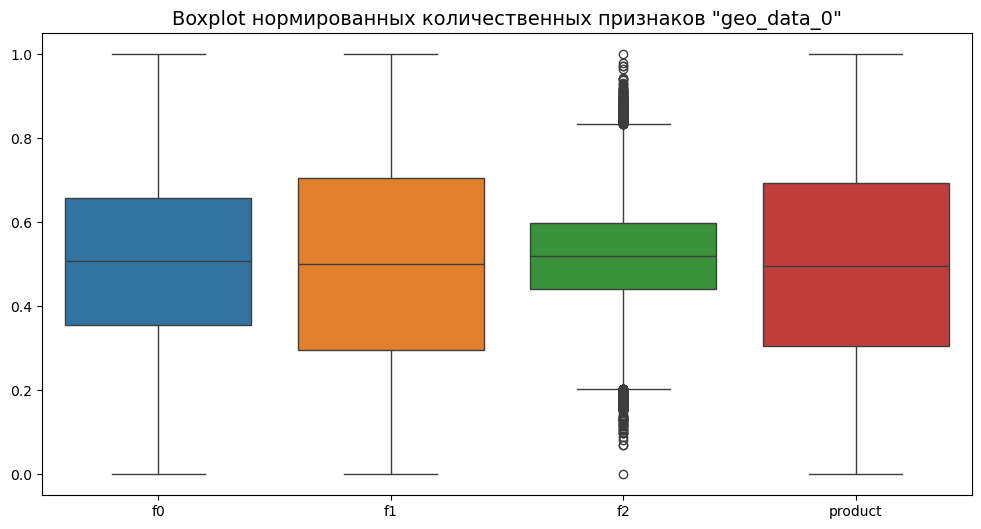

In [14]:
plt_boxplot_scaler(geo_data_0)
plt.title('Boxplot нормированных количественных признаков "geo_data_0"', fontsize=14)
plt.show()

Наблюдаются выбросы у признака `f2`, в данной задаче есть необходимость в удалении таких значений.

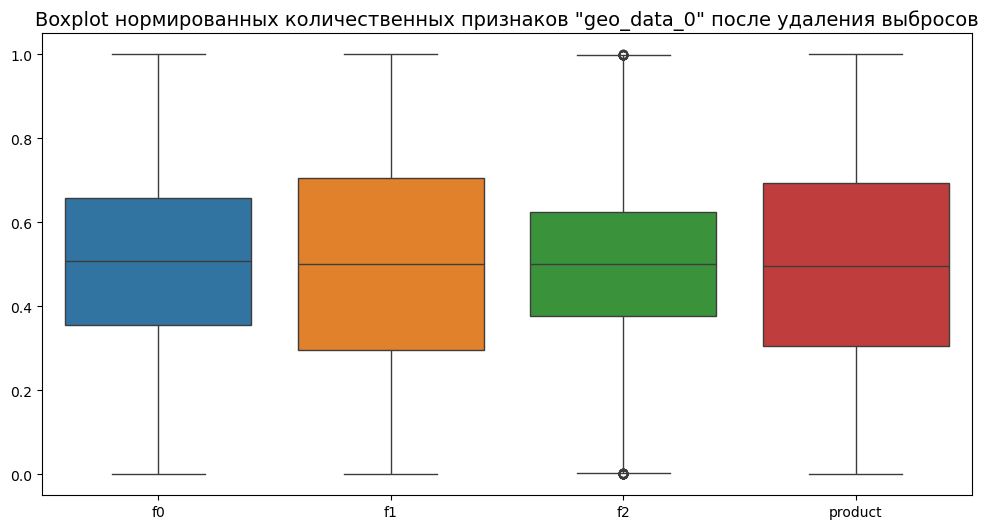

In [15]:
get_emission_free(geo_data_0)
plt.title('Boxplot нормированных количественных признаков "geo_data_0" после удаления выбросов', fontsize=14)
plt.show()

Выбросы признака `f2` в датасете **`geo_data_0`** были удалены.

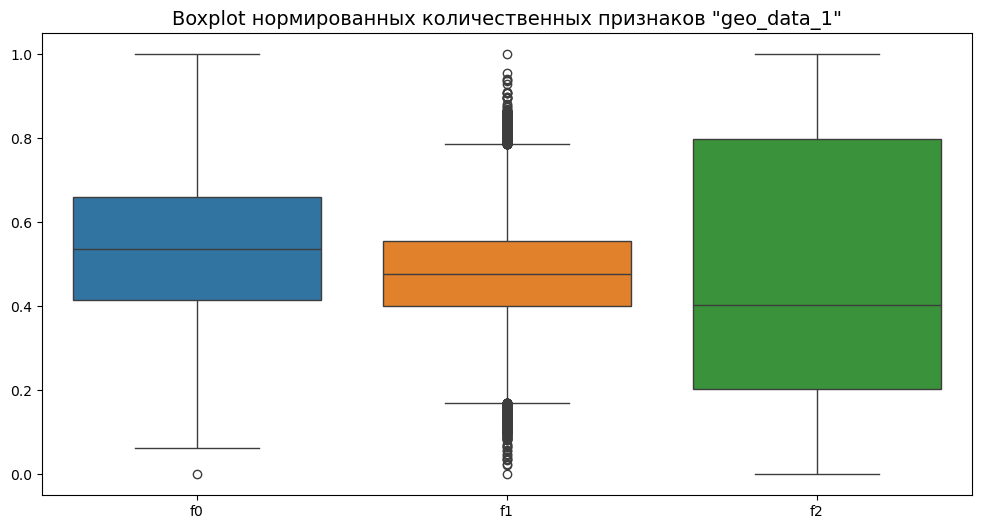

In [16]:
plt_boxplot_scaler(geo_data_1)
plt.title('Boxplot нормированных количественных признаков "geo_data_1"', fontsize=14)
plt.show()

Наблюдаются выбросы у признака `f1` и выброс у `f0`.

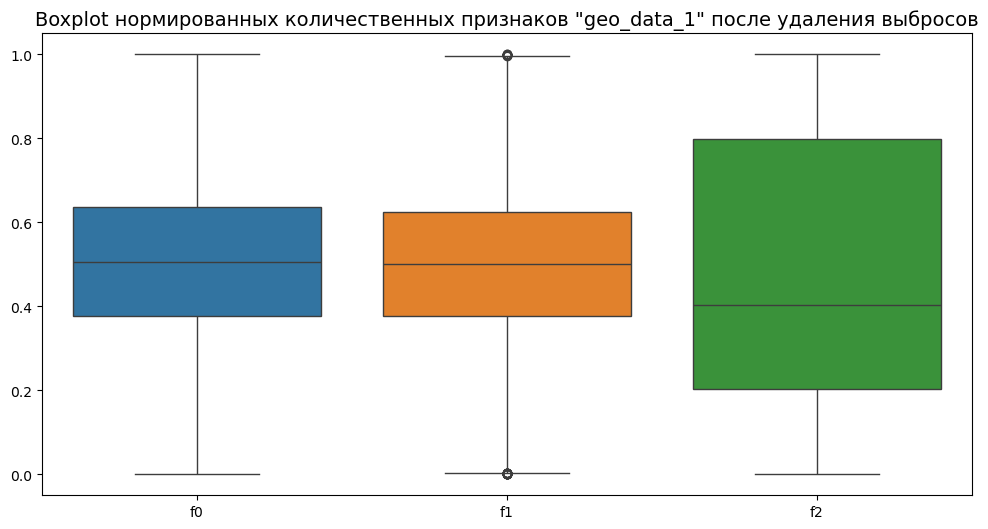

In [17]:
get_emission_free(geo_data_1)
plt.title('Boxplot нормированных количественных признаков "geo_data_1" после удаления выбросов', fontsize=14)
plt.show()

Наблюдения с выбросами признаков `f1` и `f2` были удалены из датасета **`geo_data_1`**.

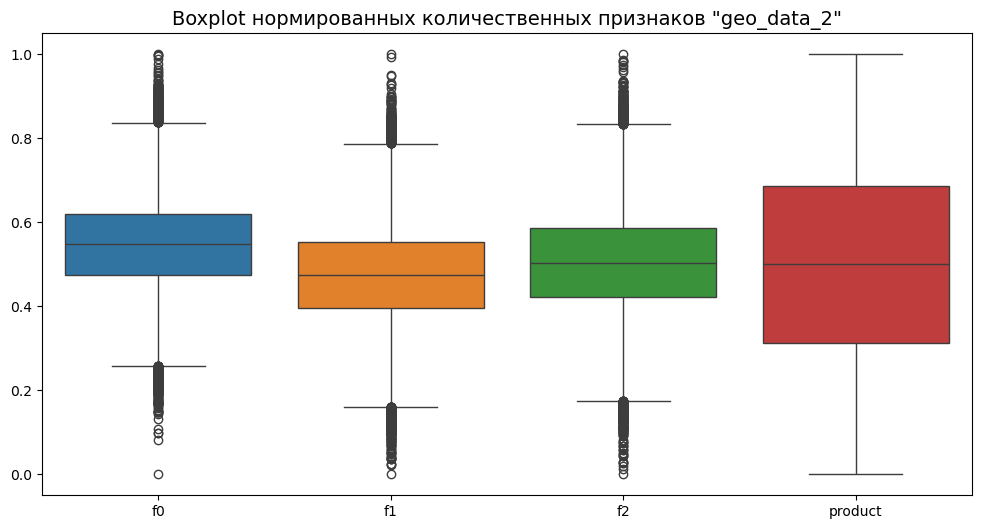

In [18]:
plt_boxplot_scaler(geo_data_2)
plt.title('Boxplot нормированных количественных признаков "geo_data_2"', fontsize=14)
plt.show()

Наблюдаются выбросы у всех входных признаков: `f0`, `f1`, `f2`.

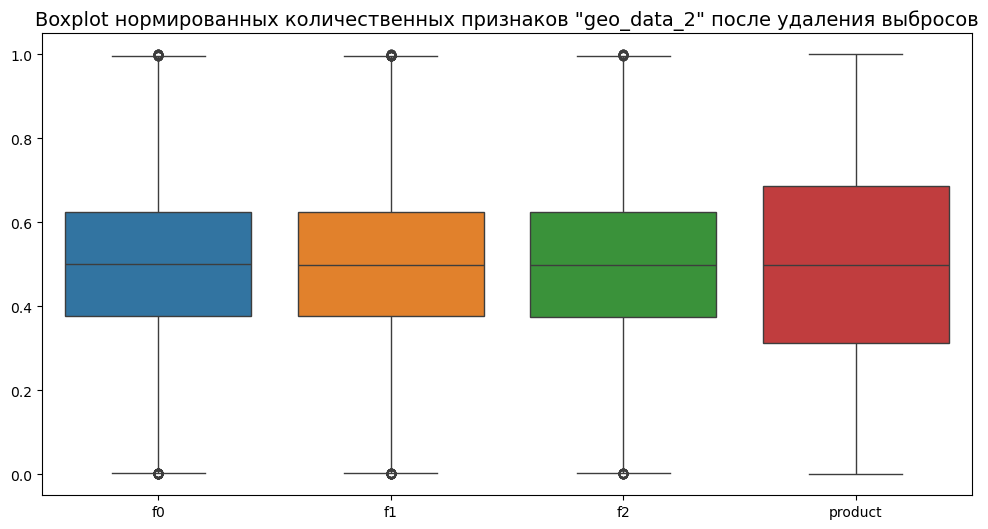

In [19]:
get_emission_free(geo_data_2)
plt.title('Boxplot нормированных количественных признаков "geo_data_2" после удаления выбросов', fontsize=14)
plt.show()

Выбросы в датасете **`geo_data_2`** были удалены.

**Промежуточный вывод:**

В каждом из датасетов имеются выбросы у признаков, которые распределены по Гауссу или бимодально. Все выбросы были убраны фильтром, используя 1.5 межквартильного размаха. Такие значения могли появиться при синтетическом создании данных по функции.

#### Что влияет на большой и малый объём запасов в скважине?

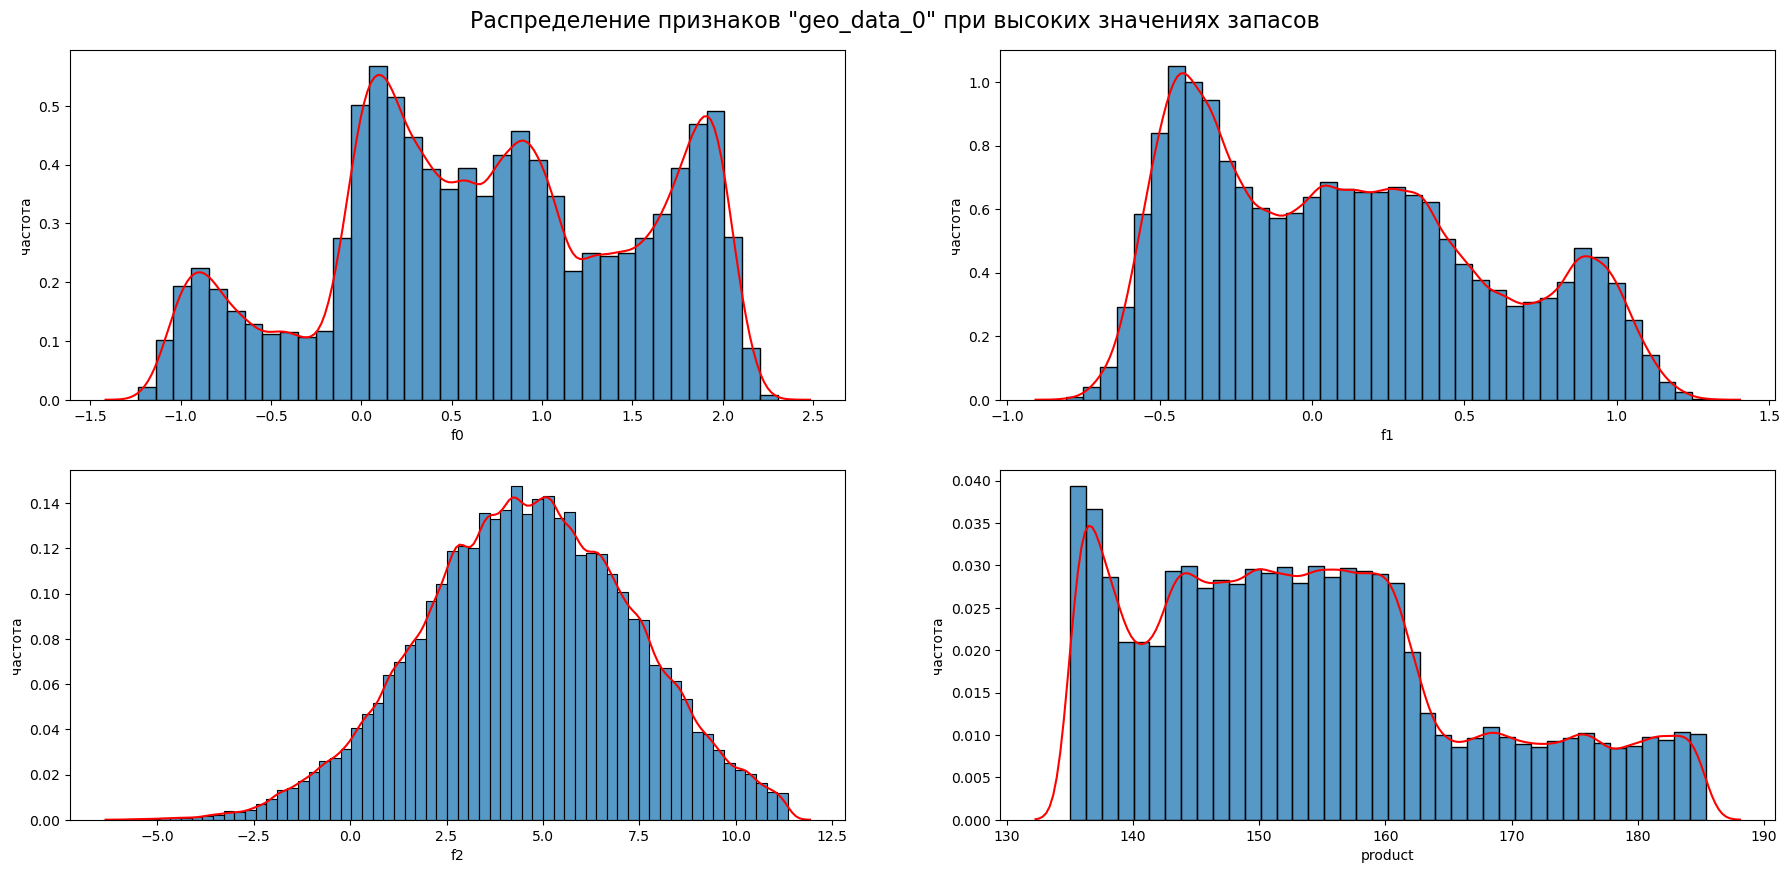

In [20]:
plt_distribution(geo_data_0.query(f'product >= {geo_data_0["product"].quantile(.8)}'))
plt.suptitle('Распределение признаков "geo_data_0" при высоких значениях запасов', fontsize=16, y=0.92)
plt.show()

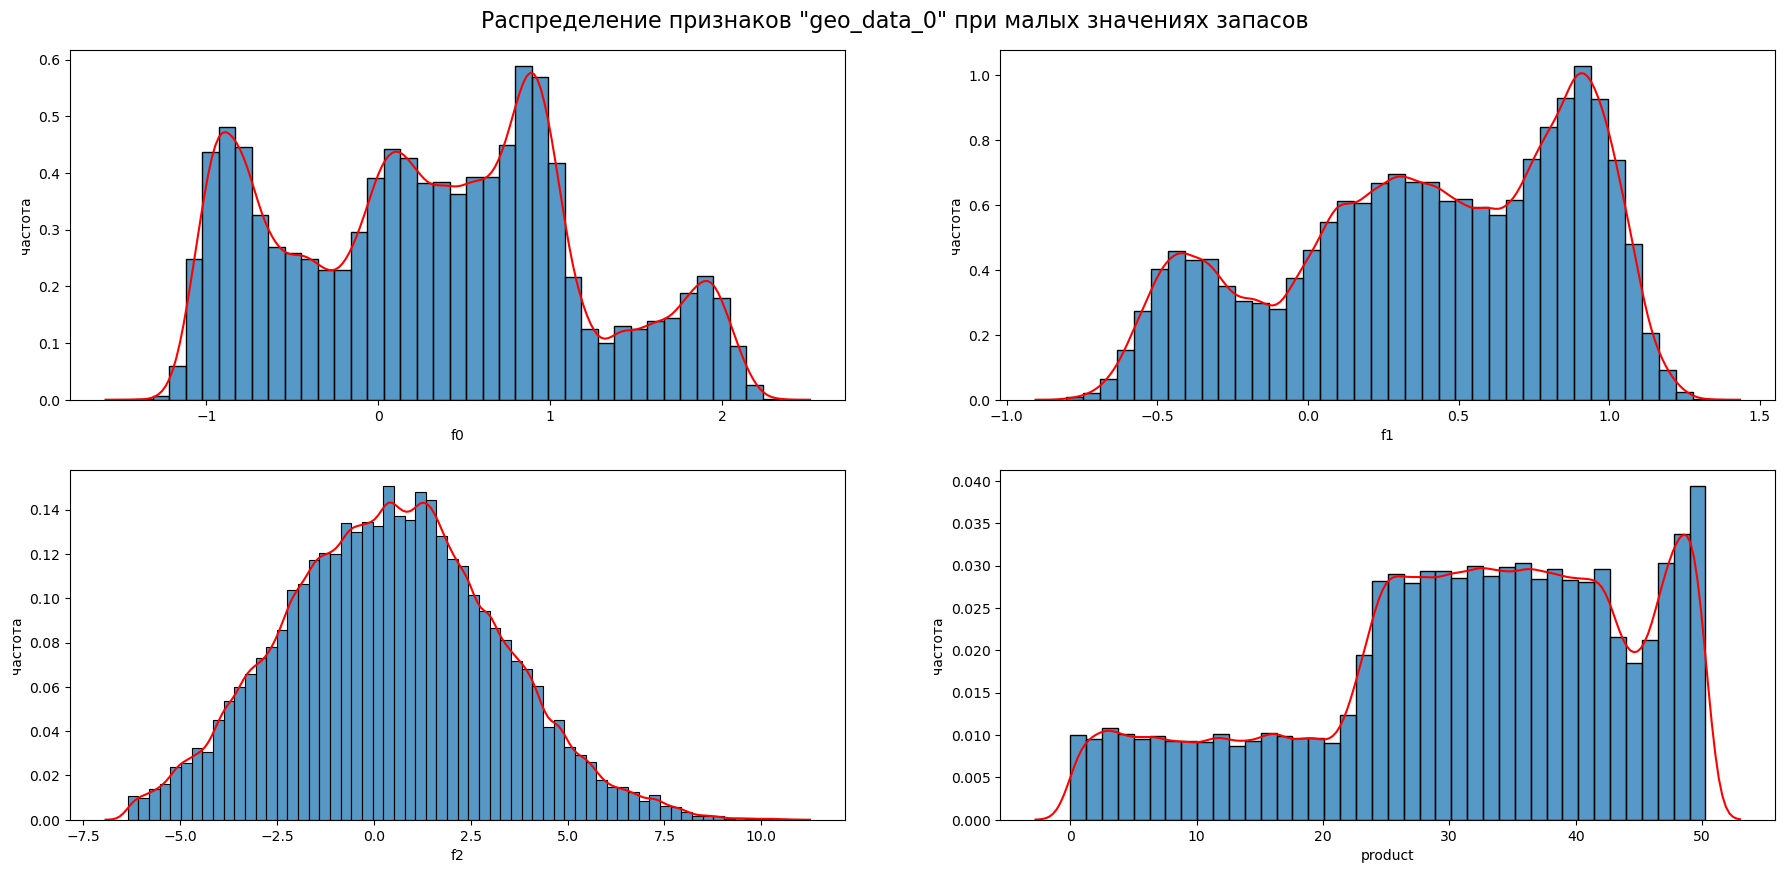

In [21]:
plt_distribution(geo_data_0.query(f'product <= {geo_data_0["product"].quantile(.2)}'))
plt.suptitle('Распределение признаков "geo_data_0" при малых значениях запасов', fontsize=16, y=0.92)
plt.show()

**Признаки и их влияние значения объёма запасов топлива в скважине для первого региона:**
- Влияние на высокие значения:
    1. `f0`: вторая и четвертая вершины имеют наибольшее влияние, а также третья. Смею предположить, что данный синтетический признак является категориальным с добавлением сильного шума для каждой из четырех категорий.
    2. `f1`: первая вершина имеет наибольшее влияние, вторая и третия по уменьшению значимости. Возможно, данный признак тоже является категориальным.
    3. `f2`: значения близкие к 3 квартилю имеют высокие значения запасов.

- Влияние на малые значения:
    1. `f0`: первая, вторая и третья вершины имеют наибольшее влияние на малые значения.
    2. `f1`: обратно пропорционально высокому значению.
    3. `f2`: значения близкие к 1 квартилю имеют малые значения запасов.

Признаки `f0` и `f1` следует перевести в категориальные. 

In [22]:
# функция для нахождения точек минимумов по оси абцисс и перевода признака в категориальный
def get_df_category(*cols, df):
    plt.figure(figsize=(22, 10))
    kde_min = {}
    
    for i, clm in enumerate(cols):
        plt.subplot(2, len(cols), i+1)
        
        # нахождение минимумов
        kde = st.gaussian_kde(df[clm], bw_method=0.07)
        x = np.linspace(df[clm].quantile(0.005), df[clm].quantile(0.995), 5000) # по 99 доверительному интервалу
        y = kde(x)

        minimum_indices = argrelextrema(y, np.less)[0]
        minimum_x = x[minimum_indices]
        
        # отрисовка количественных с минимумами
        print(f"Точки минимумов KDE({clm}):", minimum_x)
        axes = sns.histplot(data=df, x=clm, stat="density")
        for x in minimum_x:
            plt.axvline(x=x, color='r', linestyle='--', alpha=0.5)
        axes.set_ylabel('частота')
        
        # перевод в категориальный
        kde_min[clm] = [-np.inf] + minimum_x.tolist() + [np.inf]
        df[clm] = pd.cut(
                    x=df[clm],
                    bins=kde_min[clm],
                    labels=[*range(len(kde_min[clm])-1)]
                    )
        
        # отрисовка категориальных
        plt.subplot(2, len(cols), i+1+len(cols))
        axes = sns.countplot(data=df, x=clm)
        axes.set_ylabel('частота')
        
    return df

Точки минимумов KDE(f0): [-0.31291658  0.47001752  1.33850402]
Точки минимумов KDE(f1): [-0.11982462  0.63806697]


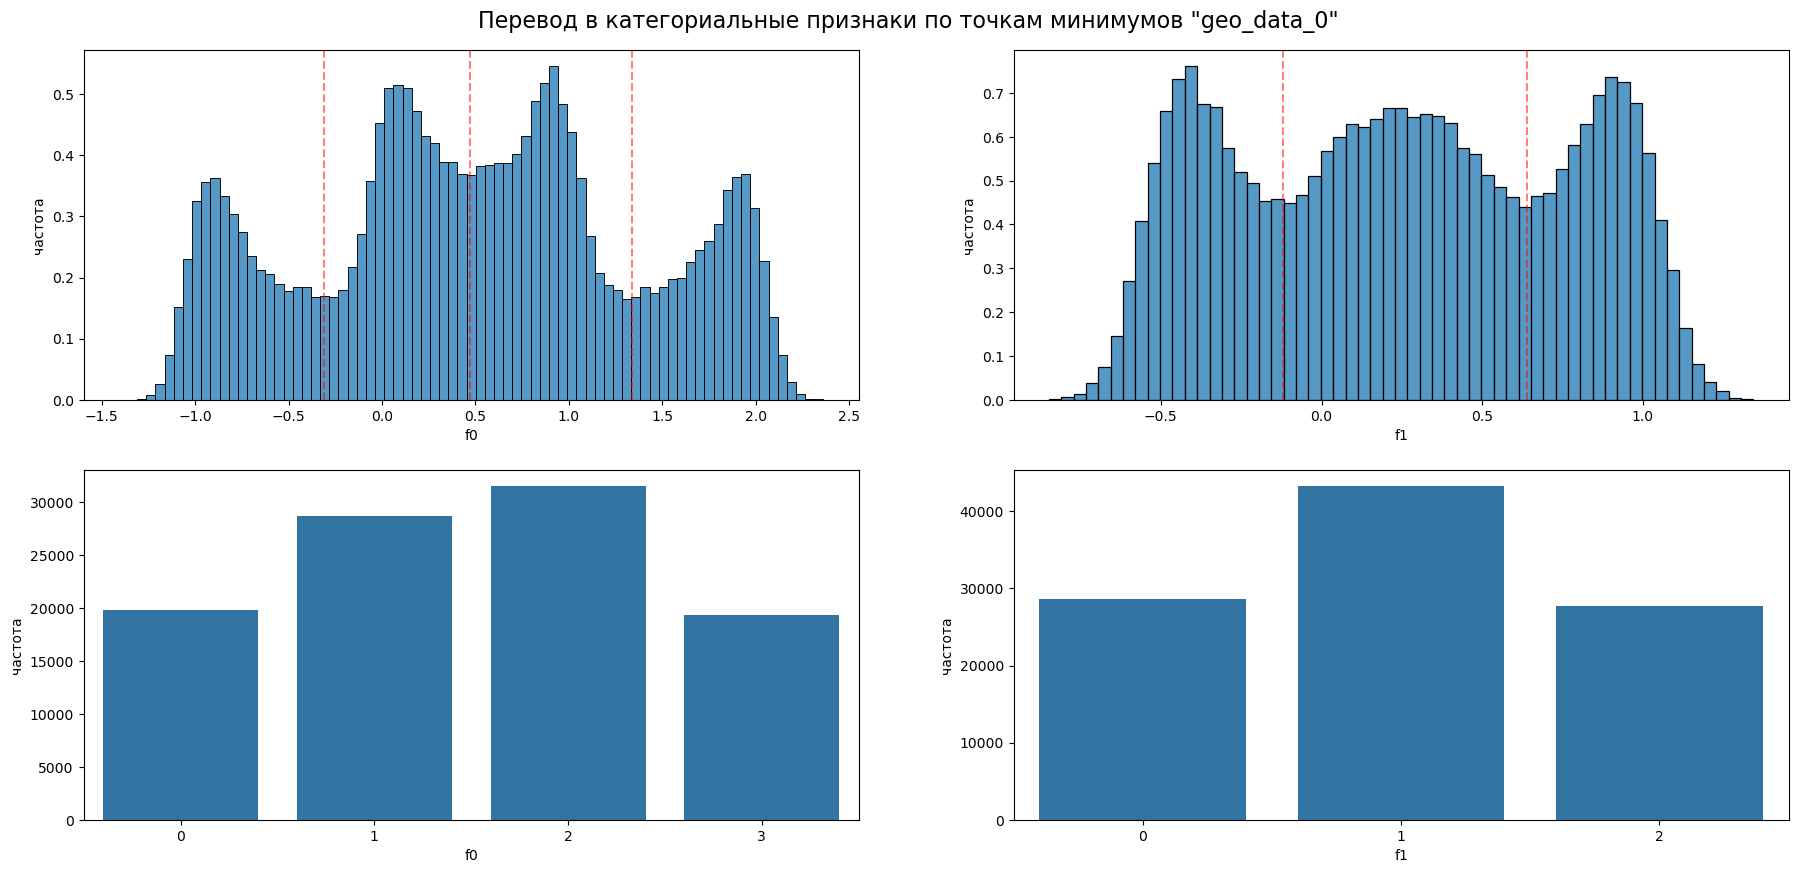

In [23]:
get_df_category('f0', 'f1', df=geo_data_0)
plt.suptitle('Перевод в категориальные признаки по точкам минимумов "geo_data_0"', fontsize=16, y=0.92)
plt.show()

In [24]:
display(geo_data_0.head())
geo_data_0.info()

,id,f0,f1,f2,product
0,txEyH,2,0,1.221170,105.280062
1,2acmU,2,0,4.365080,73.037750
2,409Wp,2,1,1.419926,85.265647
3,iJLyR,1,1,2.978566,168.620776
4,Xdl7t,3,1,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99494 entries, 0 to 99493
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       99494 non-null  object  
 1   f0       99494 non-null  category
 2   f1       99494 non-null  category
 3   f2       99494 non-null  float64 
 4   product  99494 non-null  float64 
dtypes: category(2), float64(2), object(1)
memory usage: 2.5+ MB


Признаки `f0` и `f1` были переведы в категориальные по точкам минимумов экстремумов.

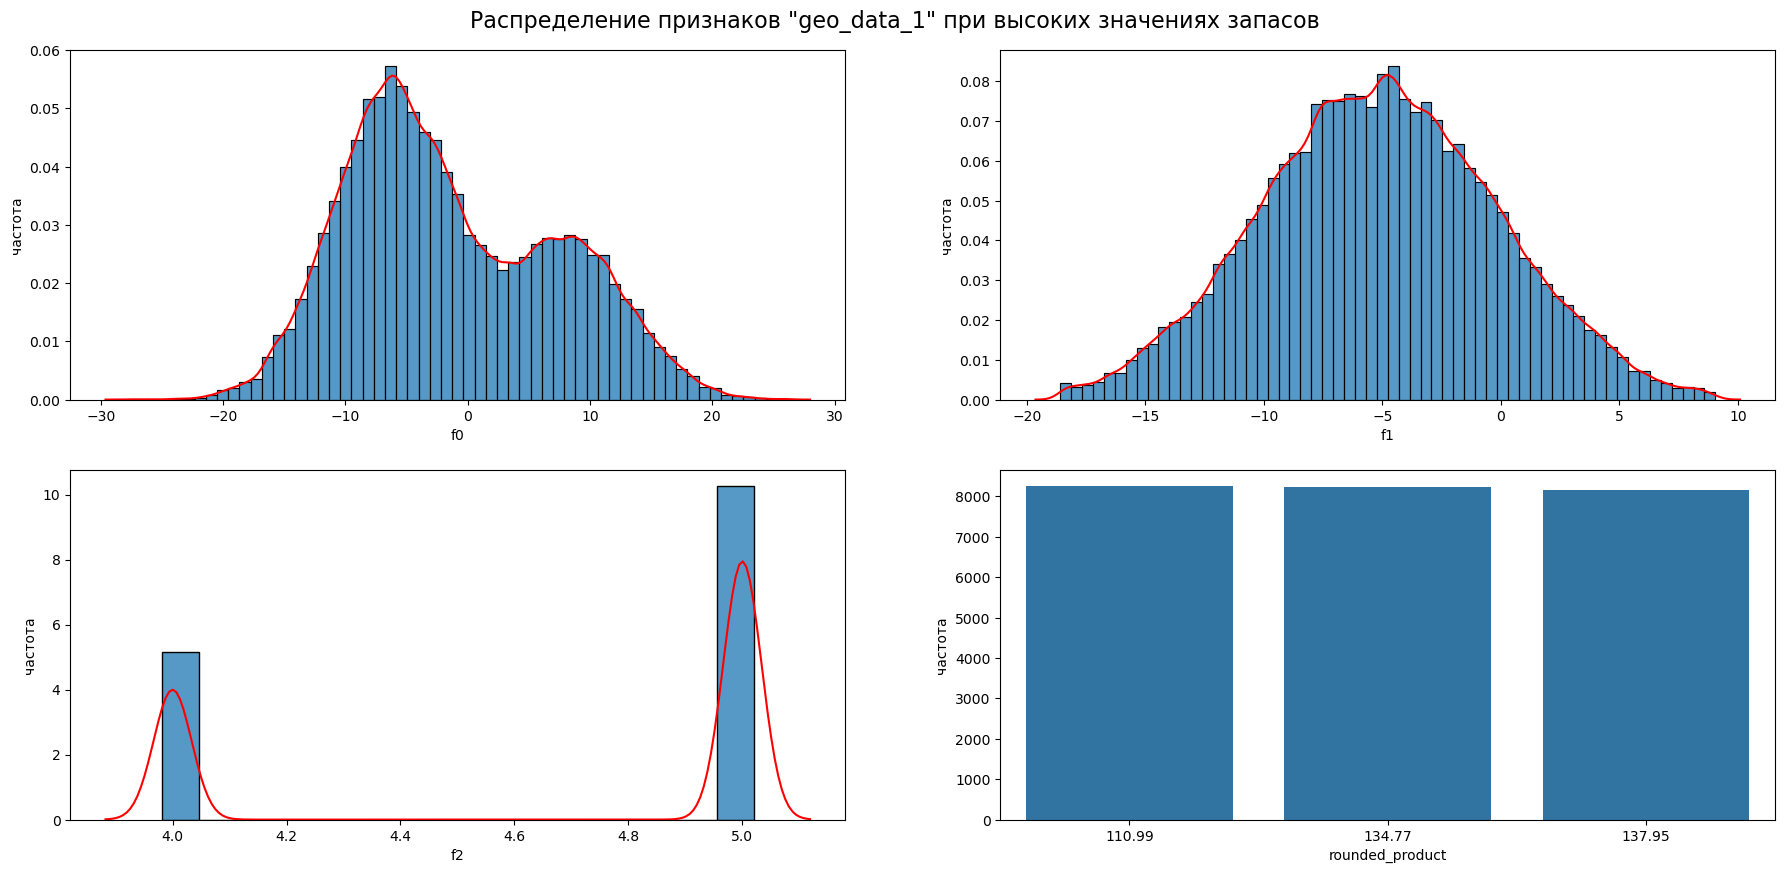

In [25]:
plt_distribution(geo_data_1.query(f'product >= {geo_data_1["product"].quantile(.8)}'))
plt.suptitle('Распределение признаков "geo_data_1" при высоких значениях запасов', fontsize=16, y=0.92)
plt.show()

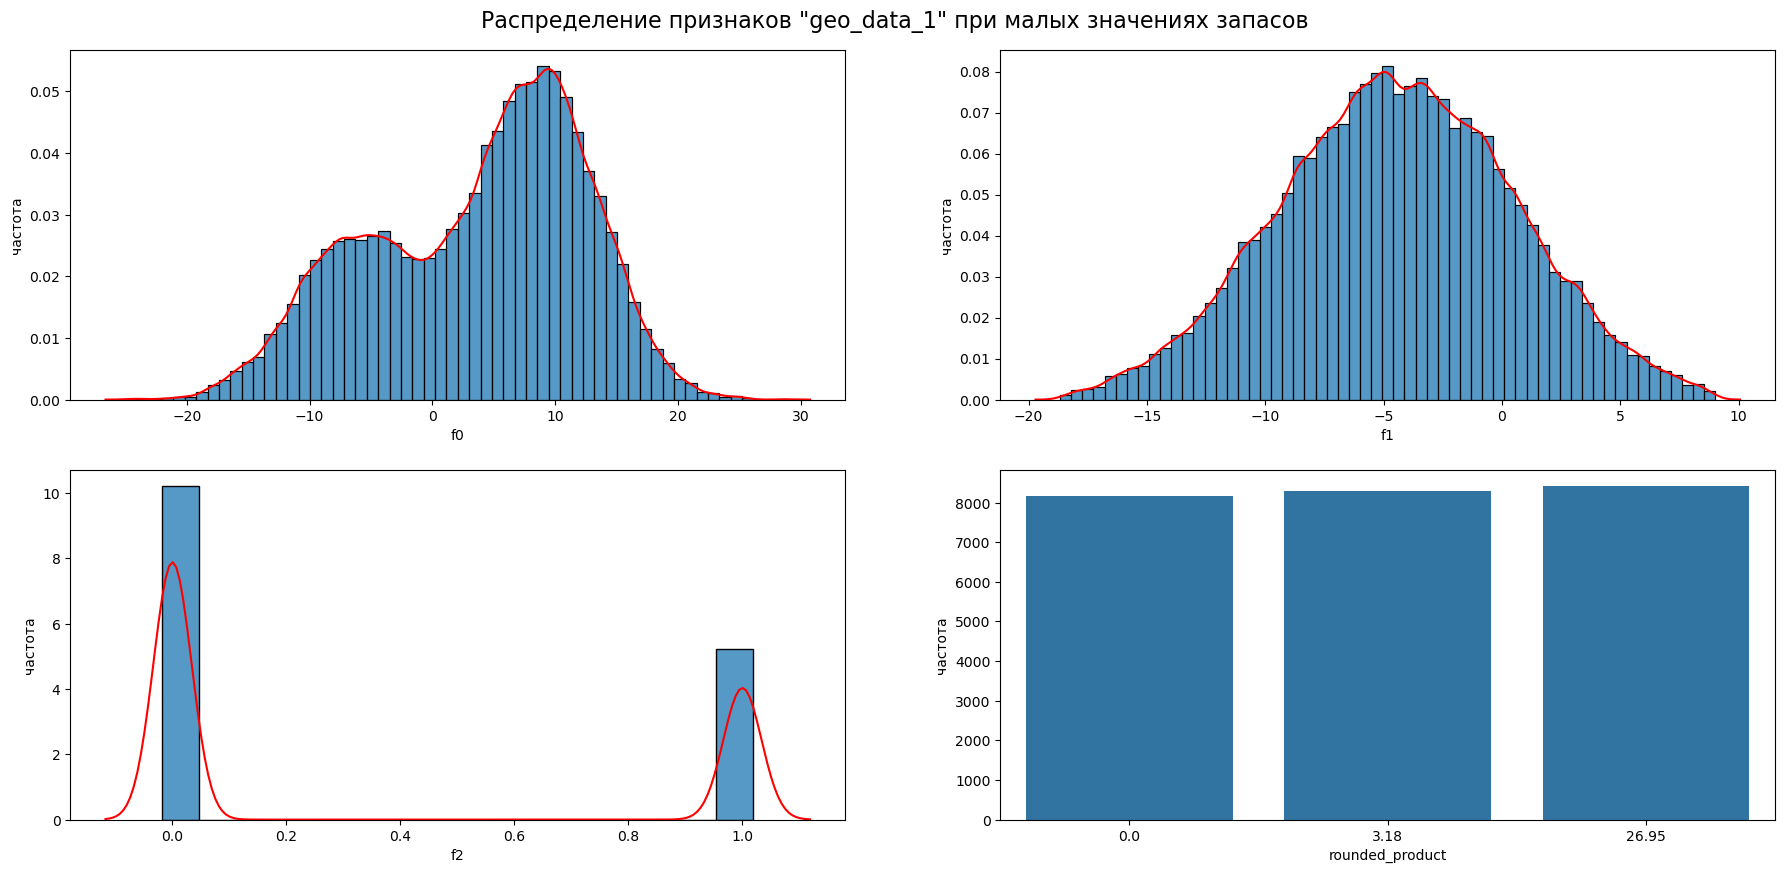

In [26]:
plt_distribution(geo_data_1.query(f'product <= {geo_data_1["product"].quantile(.2)}'))
plt.suptitle('Распределение признаков "geo_data_1" при малых значениях запасов', fontsize=16, y=0.92)
plt.show()

**Признаки и их влияние значения объёма запасов топлива в скважине для второго региона:**
- Влияние на высокие значения:
    1. `f0`: первая вершина имеет наибольшее влияние. Данный признак тоже может быть категориальным.
    2. `f1`: значения данного признака не имеют влияния на большие запасы.
    3. `f2`: значения близкие к 4 и 5 имеют высокие значения запасов.
- Влияние на малые значения:
    1. `f0`: обратно пропорционально высокому значению.
    2. `f1`: значения данного признака не имеют влияния на малые запасы.
    3. `f2`: значения близкие к 0 и 1 имеют малые значения запасов.

Признаки `f0` и `f2` стоит перевести в категориальные. Признак `f1` не имеет никакого влияния на малые и высокие значения запасов топлива в скважине.

Точки минимумов KDE(f0): [0.72011971]
Точки минимумов KDE(f2): [0.49963662 1.49959681 2.50056097 3.50052116 4.50048134]


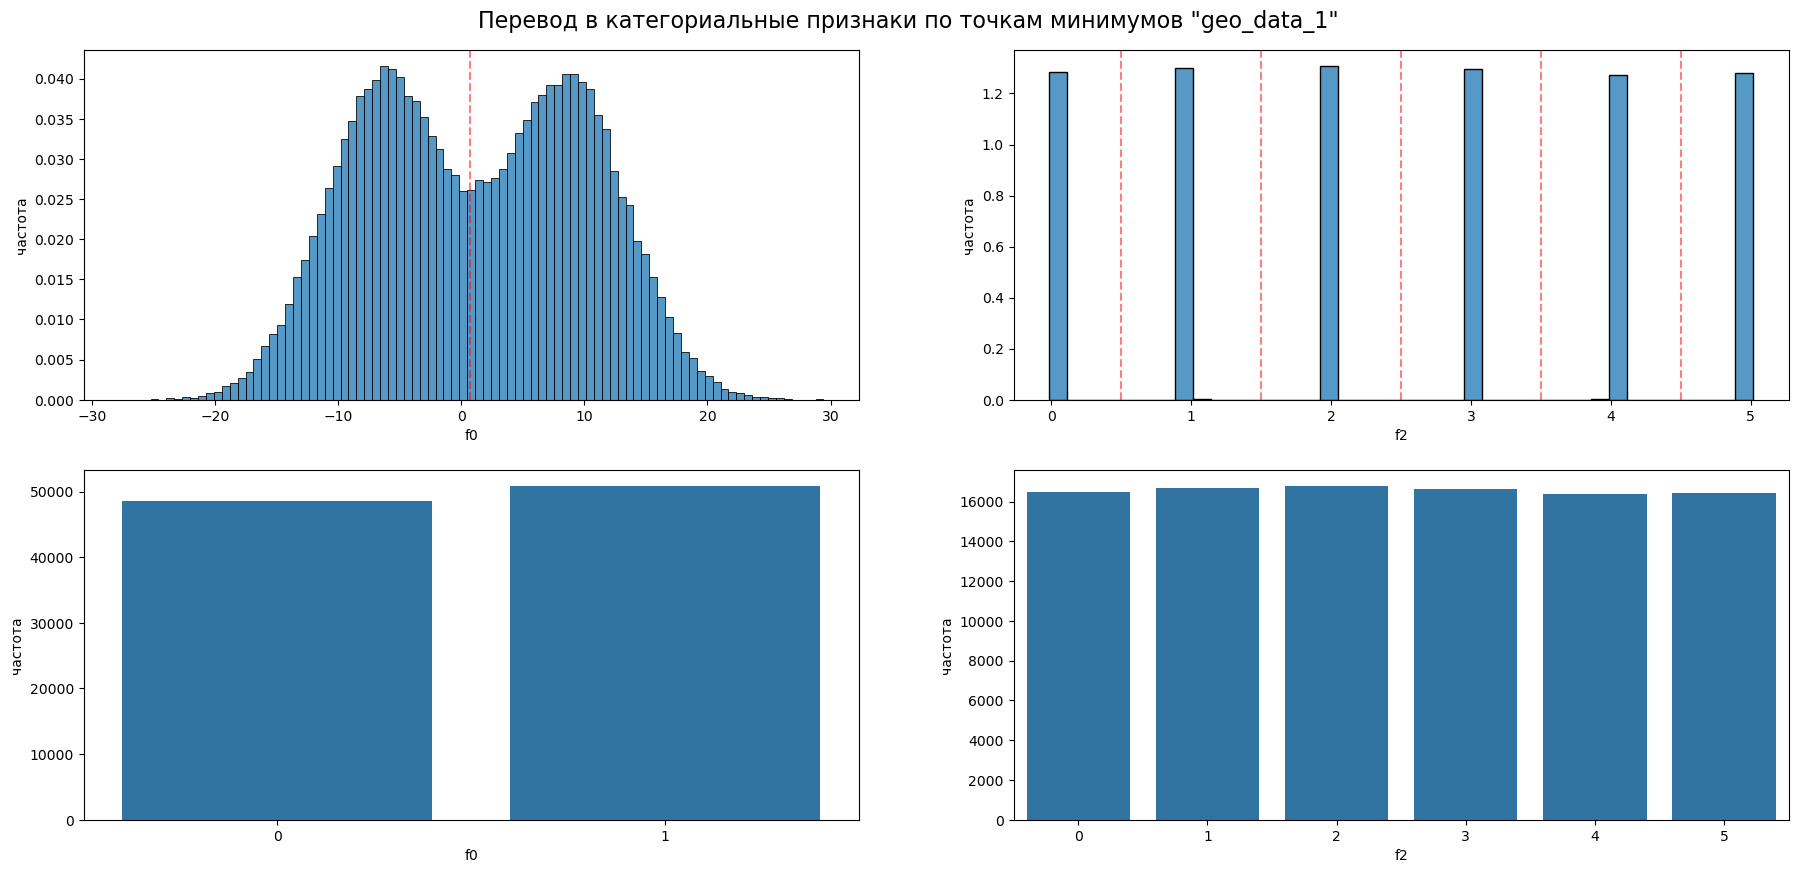

In [27]:
get_df_category('f0', 'f2', df=geo_data_1)
plt.suptitle('Перевод в категориальные признаки по точкам минимумов "geo_data_1"', fontsize=16, y=0.92)
plt.show()

In [28]:
display(geo_data_1.head())
geo_data_1.info()

,id,f0,f1,f2,product
0,kBEdx,0,-8.276000,0,3.179103
1,62mP7,1,-3.475083,1,26.953261
2,vyE1P,1,-5.948386,5,134.766305
3,KcrkZ,0,-11.506057,5,137.945408
4,AHL4O,1,-8.147433,5,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99363 entries, 0 to 99362
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   id       99363 non-null  object  
 1   f0       99363 non-null  category
 2   f1       99363 non-null  float64 
 3   f2       99363 non-null  category
 4   product  99363 non-null  float64 
dtypes: category(2), float64(2), object(1)
memory usage: 2.5+ MB


Признаки `f0` и `f2` были переведы в категориальные по точкам минимумов экстремумов.

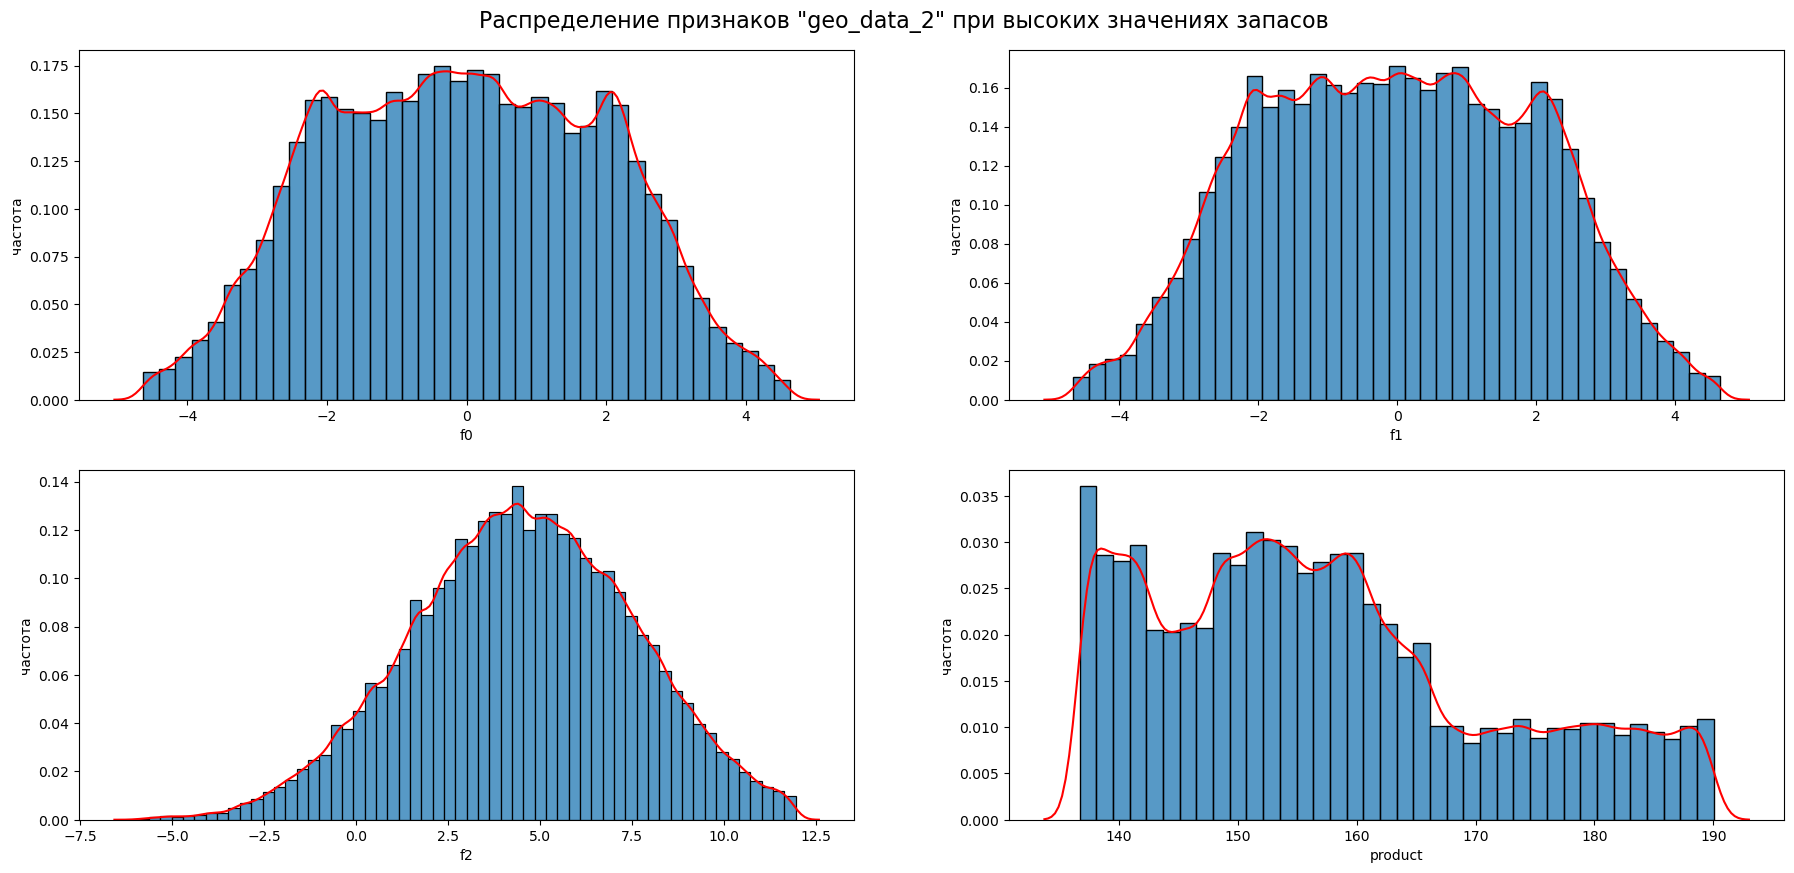

In [29]:
plt_distribution(geo_data_2.query(f'product >= {geo_data_2["product"].quantile(.8)}'))
plt.suptitle('Распределение признаков "geo_data_2" при высоких значениях запасов', fontsize=16, y=0.92)
plt.show()

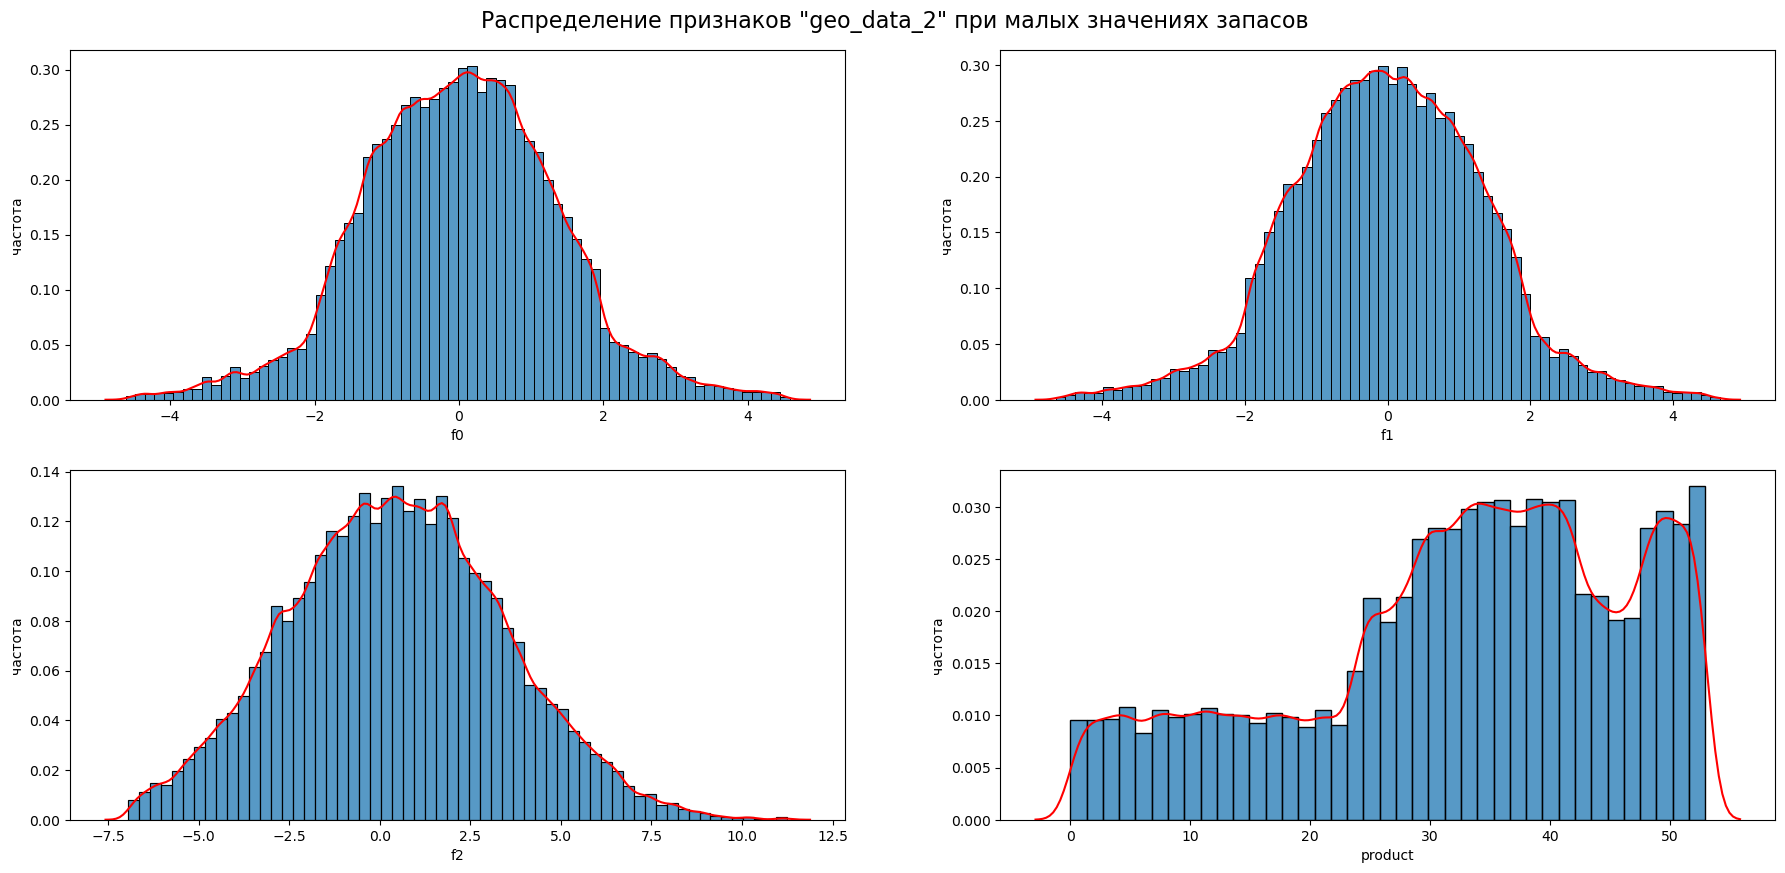

In [30]:
plt_distribution(geo_data_2.query(f'product <= {geo_data_2["product"].quantile(.2)}'))
plt.suptitle('Распределение признаков "geo_data_2" при малых значениях запасов', fontsize=16, y=0.92)
plt.show()

**Признаки и их влияние значения объёма запасов топлива в скважине для третьего региона:**
- Влияние на высокие значения:
    1. `f0`: значения находящиеся в 50% доверительном интервале.
    2. `f1`: значения находящиеся в 50% доверительном интервале.
    3. `f2`: значения близкие к 3 квартилю.
- Влияние на малые значения:
    1. `f0`: значения близкие к 0 (медиане)
    2. `f1`: значения близкие к 0 (медиане)
    3. `f2`: значения близкие к 1 квартилю.

Значения признаков `f0` и `f1` имеют неоднозначное влияние на малые запасы топлива.

**Промежуточный вывод:**

Признаки `f0` и `f1` датасета **`geo_data_0`** и `f0`, `f2` датасета **`geo_data_1`** были переведы в категориальные по точкам минимумов экстремумов.

#### Корреляционный анализ

In [31]:
def plt_scatter(df):
    plt.figure(figsize=(16, 6))
    cols = df.columns[1:-1]
    for i, clm in enumerate(cols):
        plt.subplot(1, 3, i+1)
        plt.hexbin(x=df['product'], y=df[clm], gridsize=50, cmap='Blues', mincnt=1)
        plt.ylabel(clm)
        plt.xlabel('product')

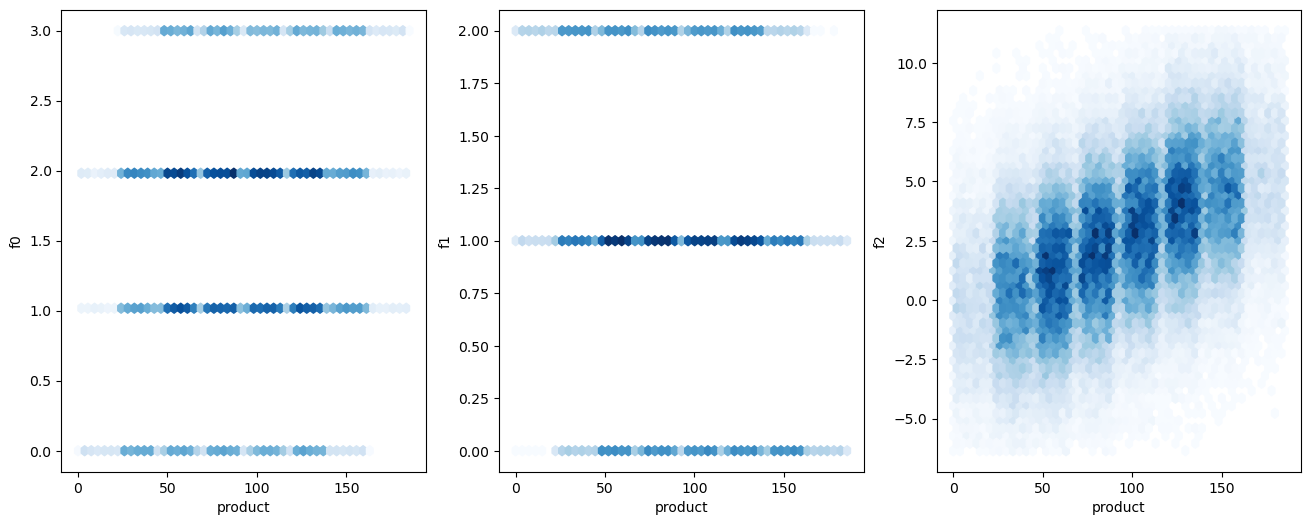

In [32]:
plt_scatter(geo_data_0)

Признаки `f0`, `f1` датасета **`geo_data_0`**  не имеют линейной связи. Признак `f2` имеет очень слабую положительную связь.

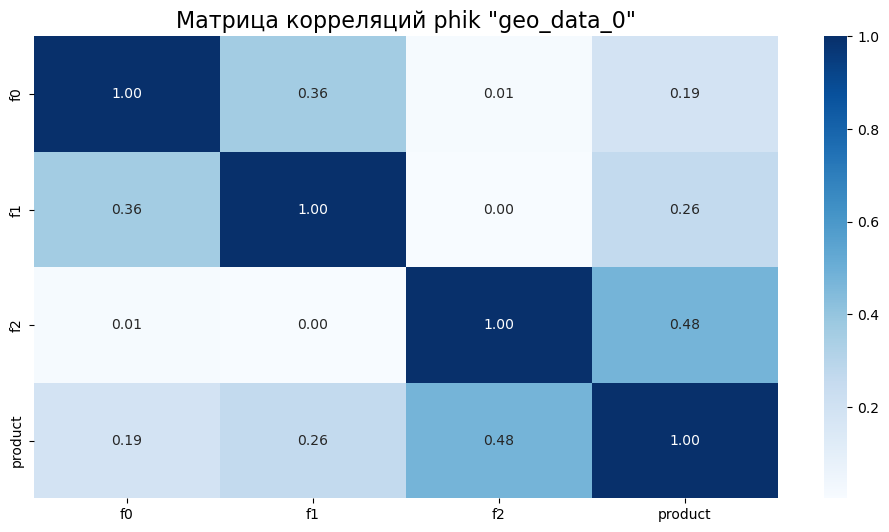

In [33]:
plt.figure(figsize=(12, 6))

sns.heatmap(
        geo_data_0.iloc[:, 1:].phik_matrix(interval_cols=['f2', 'product']),
        annot=True,
        fmt='.2f',
        cmap='Blues'
)

plt.title('Матрица корреляций phik "geo_data_0"', fontsize=16)
plt.show()

Связь признаков с целевым:
- `f0`: 0.19
- `f1`: 0.26
- `f2`: 0.42

Непрерывный признак `f2` имеет наибольшую связь среди входных признаков. Мультиколлениарность не наблюдается.

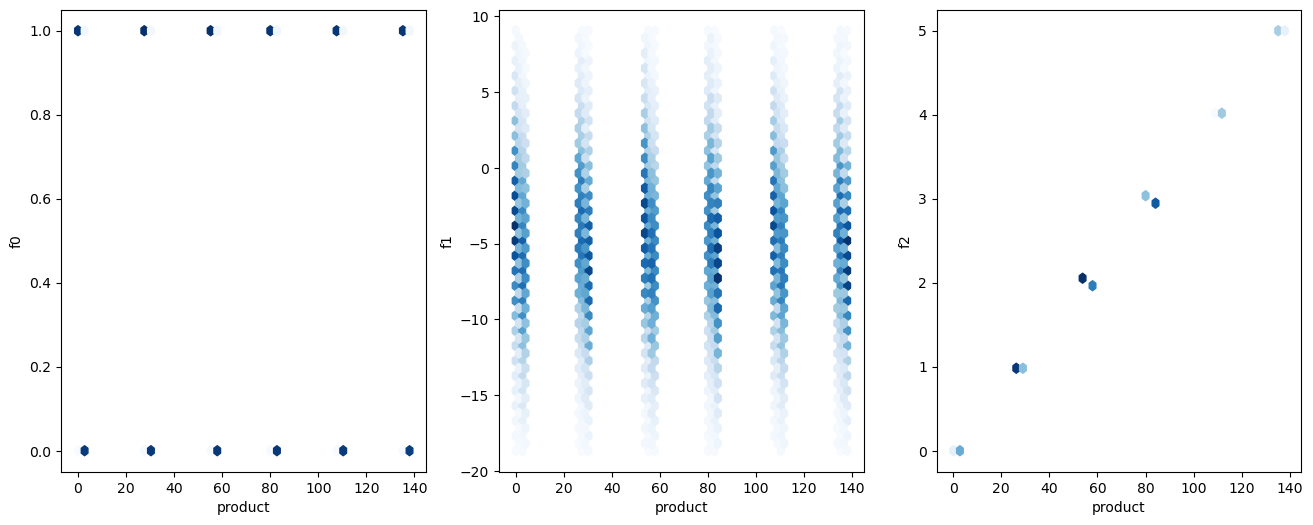

In [34]:
plt_scatter(geo_data_1)

Признак `f2` датасета **`geo_data_1`** имеет сильную прямую положительную связь с целевым. Признаки `f0` и `f1` не имеют линейной связи с `product`.

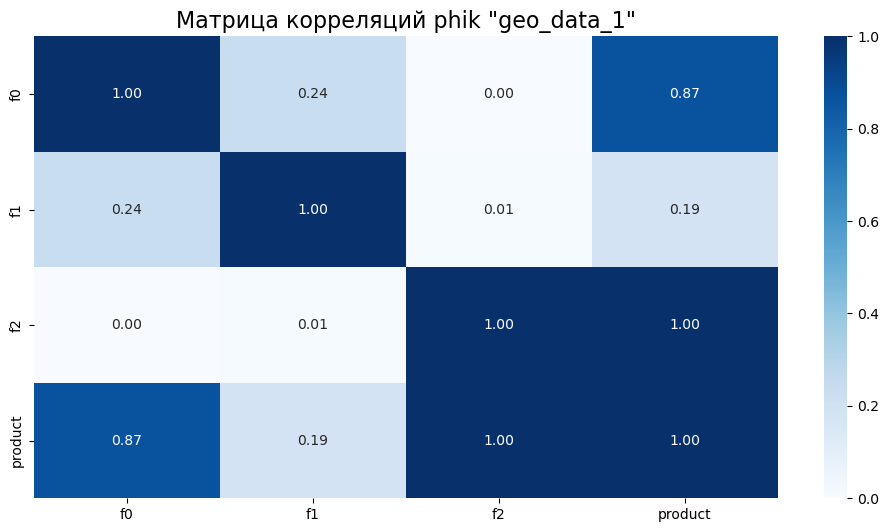

In [35]:
plt.figure(figsize=(12, 6))

sns.heatmap(
        geo_data_1.iloc[:, 1:].phik_matrix(interval_cols=['f1', 'product']),
        annot=True,
        fmt='.2f',
        cmap='Blues'
)

plt.title('Матрица корреляций phik "geo_data_1"', fontsize=16)
plt.show()

Связь признаков с целевым:
- `f0`: 0.87
- `f1`: 0.19
- `f2`: 1.00

Признак `f0` имеет высокую связь, а `f2` имеет идеальную положительную связь с целевым. Мультиколлениарность не наблюдается.

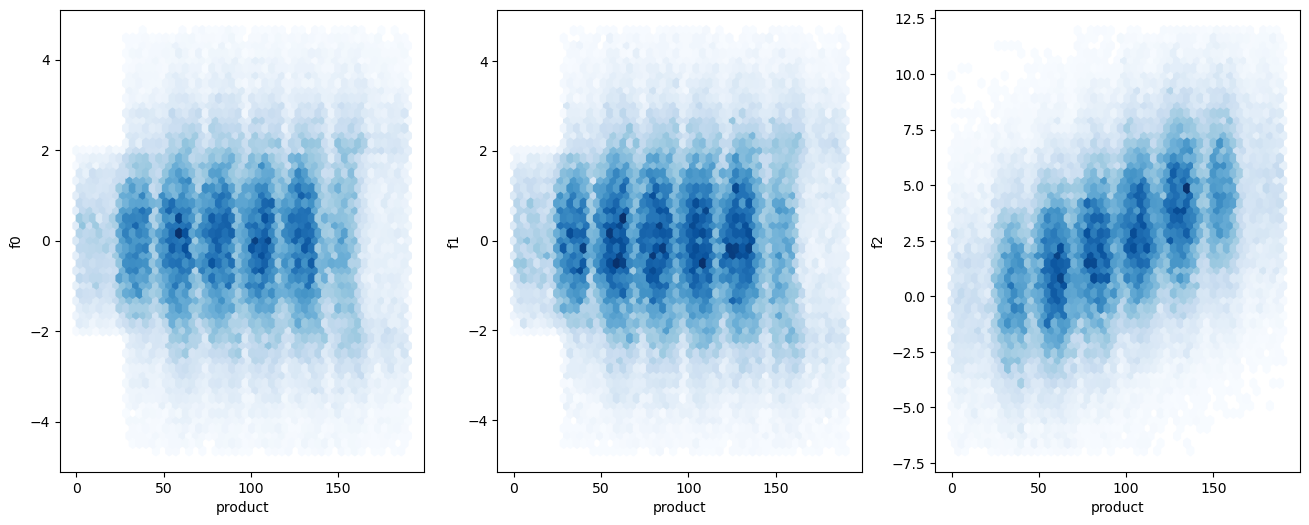

In [36]:
plt_scatter(geo_data_2)

Признак `f2` имеет очень слабую положительную связь. Признаки `f0` и `f1` не имеют явной связи с `product`.

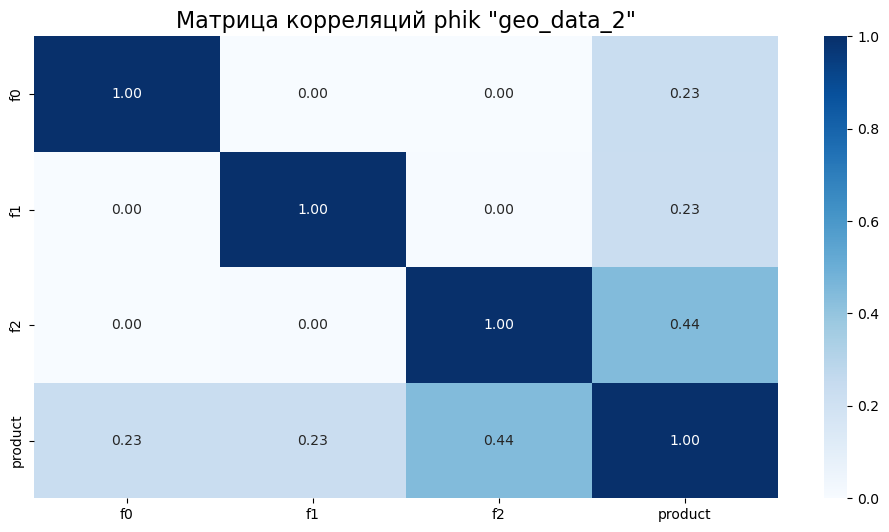

In [37]:
plt.figure(figsize=(12, 6))

sns.heatmap(
        geo_data_2.iloc[:, 1:].phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product']),
        annot=True,
        fmt='.2f',
        cmap='Blues'
)

plt.title('Матрица корреляций phik "geo_data_2"', fontsize=16)
plt.show()

Связь признаков с целевым:
- `f0`: 0.23
- `f1`: 0.23
- `f2`: 0.44

Признак `f2` имеет наибольшую связь среди входных признаков. Мультиколлениарность не наблюдается.

#### Вывод исследовательского анализа

В каждом из датасетов данные являются синтетическими. \
В регионе **`geo_data_1`** количество запасов в скважине имеет равномерное распределение, признак состоит из 12 уникальных категорий и наибольшее значение - 138 тыс. баррелей, что меньше по сравнению с двумя другими регионами \
В каждом из датасетов имеются выбросы у признаков, которые распределены по Гауссу или бимодально. Все выбросы были убраны фильтром, используя 1.5 межквартильного размаха. \
Признаки `f0` и `f1` датасета **`geo_data_0`** и `f0`, `f2` датасета **`geo_data_1`** были переведы в категориальные по точкам минимумов экстремумов.  \
Признак `f1` из датасета **`geo_data_1`** не имеет никакого влияния на малые и высокие значения запасов топлива в скважине.

Связь признаков с целевым:
- **`geo_data_0`**
    - `f0`: 0.19
    - `f1`: 0.26
    - `f2`: 0.42
- **`geo_data_1`**
    - `f0`: 0.87
    - `f1`: 0.19
    - `f2`: 1.00
- **`geo_data_2`**
    - `f0`: 0.23
    - `f1`: 0.23
    - `f2`: 0.44

### [Подготовка данных и обучение модели](#task_4_plan) <a id='task_4'></a>

#### Подготовка данных

In [38]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
                                                geo_data_0.drop(['id', 'product'], axis=1),
                                                geo_data_0['product'],
                                                random_state=RANDOM_STATE,
                                                test_size=0.25
                                        )


X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
                                                geo_data_1.drop(['id', 'product', 'f1'], axis=1),
                                                geo_data_1['product'],
                                                random_state=RANDOM_STATE,
                                                test_size=0.25
                                        )


X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
                                                geo_data_2.drop(['id', 'product'], axis=1),
                                                geo_data_2['product'],
                                                random_state=RANDOM_STATE,
                                                test_size=0.25
                                        )

Данные каждого региона были поделены на тренировочные и валидационные в пропорции 75/25.

In [39]:
scaled_pipe = Pipeline(
    [('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('scaled', MinMaxScaler())]
)

pipe_final = Pipeline([
    ('preprocessor', scaled_pipe),
    ('models', LinearRegression())
])

In [40]:
params = {'models__fit_intercept': [True,False],
          'models__positive': [True,False],
          'preprocessor__scaled': [StandardScaler(), MinMaxScaler(), None]}


grid = GridSearchCV(
    pipe_final,
    param_grid=params,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

Создан пайплайн с предобработкой пропусков и масштабированием признаков.

#### Обучение моделей

In [41]:
# Графики остатков
def residuals_plot(y_true, y_pred):
    plt.figure(figsize=(14, 5))
    
    residuals = y_true - y_pred

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Гистограмма распределения остатков')
    plt.ylabel('остатки')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_pred, y=residuals)
    sns.regplot(x=y_pred, y=residuals, order=2)
    plt.title('Анализ дисперсии')
    plt.xlabel('предсказание')
    plt.ylabel('остатки')

    plt.show()

In [42]:
grid.fit(X_train_0, y_train_0)
display(pd.DataFrame(data=grid.cv_results_).sort_values(by='rank_test_score'))

model_0 = grid.best_estimator_.named_steps['models']
preprocess_0 = grid.best_estimator_.named_steps['preprocessor']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__fit_intercept,param_models__positive,param_preprocessor__scaled,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.026205,0.000683,0.004076,0.000834,True,False,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-37.916110,-37.436985,-38.090372,-37.814489,0.276253,1
4,0.028405,0.004641,0.003733,0.000912,True,False,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-37.916110,-37.436985,-38.090372,-37.814489,0.276253,1
5,0.027056,0.002033,0.003148,0.001251,True,False,None,"{'models__fit_intercept': True, 'models__posit...",-37.916110,-37.436985,-38.090372,-37.814489,0.276253,1
0,0.029713,0.004594,0.002755,0.000662,True,True,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-38.462322,-37.951593,-38.582154,-38.332023,0.273417,4
1,0.030444,0.005114,0.003050,0.001037,True,True,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-38.462322,-37.951593,-38.582154,-38.332023,0.273417,4
2,0.026646,0.004390,0.003250,0.000456,True,True,None,"{'models__fit_intercept': True, 'models__posit...",-38.462322,-37.951593,-38.582154,-38.332023,0.273417,4
10,0.018169,0.000343,0.001827,0.000149,False,False,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-39.178925,-38.601121,-39.237372,-39.005806,0.287148,7
7,0.019073,0.000715,0.002279,0.000390,False,True,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-39.196912,-38.620650,-39.254093,-39.023885,0.286084,8
8,0.017555,0.000478,0.001736,0.000428,False,True,None,"{'models__fit_intercept': False, 'models__posi...",-46.873280,-46.283282,-46.743119,-46.633227,0.253090,9
11,0.014989,0.000605,0.001206,0.000103,False,False,None,"{'models__fit_intercept': False, 'models__posi...",-46.873280,-46.283282,-46.743119,-46.633227,0.253090,9


Средний запас сырья: 92.41
Средний запас предсказанного сырья: 92.43
RMSE: 37.77
r2: 0.27


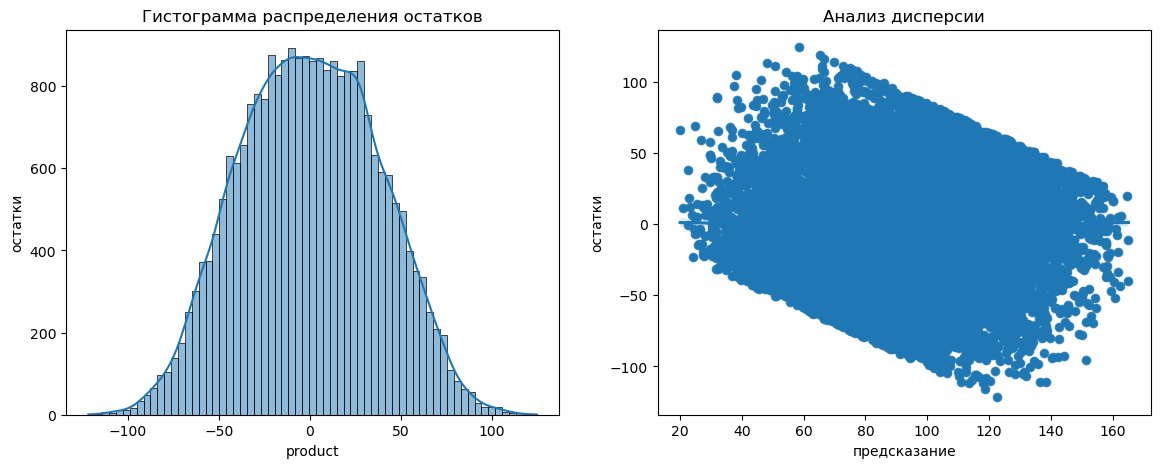

In [43]:
pred_0 = model_0.predict(preprocess_0.transform(X_valid_0))

print('Средний запас сырья:', round(y_valid_0.mean(), 2))
print('Средний запас предсказанного сырья:', round(pred_0.mean(), 2))
print('RMSE:', round(root_mean_squared_error(y_valid_0, pred_0), 2))
print('r2:', round(r2_score(y_valid_0, pred_0), 2))

residuals_plot(y_valid_0, pred_0)

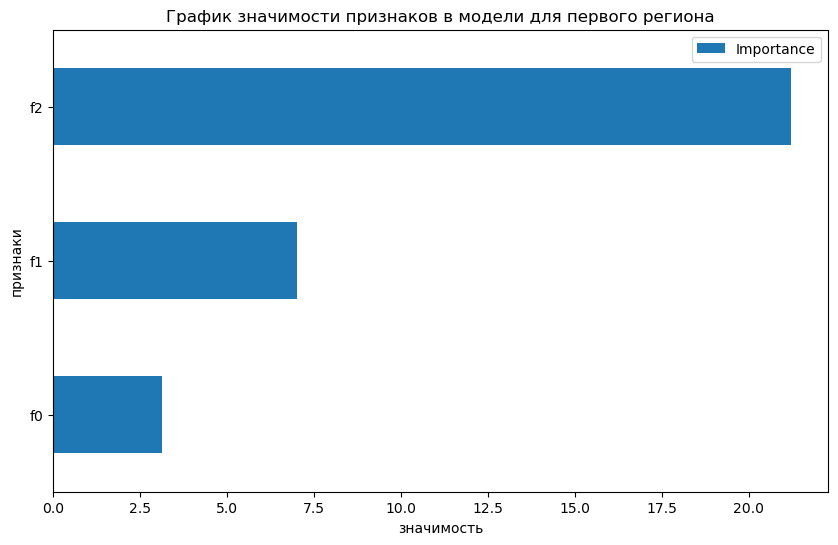

In [44]:
feature_importance = pd.DataFrame({'Feature': preprocess_0.get_feature_names_out(),
                                   'Importance': np.abs(model_0.coef_)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.title('График значимости признаков в модели для первого региона')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

Лучшая модель для первого региона имеет параметры: fit_intercept=True, positive=False. \
Признак `f2` имеет наибольшую значимость в предсказательной способности модели. \
Метрики на валидационном наборе:
- RMSE: 37.77
- r2: 0.27

В 27% случаев предсказание модели ближе к истине, чем среднее значение целевого признака, что не является хорошим результатом. Судя по гистограмме распределения остатков, модель не имеет систематических ошибок, а просто не объясняет данные должным образом. 

Средний запас сырья: 92.41 \
Средний запас предсказанного сырья: 92.43

In [45]:
grid.fit(X_train_1, y_train_1)
display(pd.DataFrame(data=grid.cv_results_).sort_values(by='rank_test_score'))

model_1 = grid.best_estimator_.named_steps['models']
preprocess_1 = grid.best_estimator_.named_steps['preprocessor']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__fit_intercept,param_models__positive,param_preprocessor__scaled,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.025391,0.002649,0.002956,0.000843,True,False,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-0.806677,-0.804350,-0.809584,-0.806870,0.002141,1
4,0.019176,0.001864,0.002484,0.001085,True,False,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-0.806677,-0.804350,-0.809584,-0.806870,0.002141,1
5,0.012996,0.000833,0.001963,0.000446,True,False,None,"{'models__fit_intercept': True, 'models__posit...",-0.806677,-0.804350,-0.809584,-0.806870,0.002141,1
0,0.024652,0.005793,0.003759,0.002865,True,True,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-1.589774,-1.589547,-1.589691,-1.589670,0.000094,4
1,0.019863,0.006434,0.002820,0.001738,True,True,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-1.589774,-1.589547,-1.589691,-1.589670,0.000094,5
2,0.015829,0.000670,0.003647,0.001946,True,True,None,"{'models__fit_intercept': True, 'models__posit...",-1.589774,-1.589547,-1.589691,-1.589670,0.000094,6
10,0.022889,0.001664,0.002931,0.000545,False,False,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-1.665372,-1.661441,-1.670947,-1.665920,0.003900,7
11,0.016862,0.003616,0.001950,0.001163,False,False,None,"{'models__fit_intercept': False, 'models__posi...",-1.665372,-1.661441,-1.670947,-1.665920,0.003900,7
8,0.013646,0.001023,0.003085,0.001213,False,True,None,"{'models__fit_intercept': False, 'models__posi...",-1.822088,-1.815534,-1.826151,-1.821258,0.004374,9
7,0.012985,0.000810,0.001925,0.000463,False,True,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-1.822088,-1.815534,-1.826151,-1.821258,0.004374,10


Средний запас сырья: 68.84
Средний запас предсказанного сырья: 68.83
RMSE: 0.8
r2: 1.0


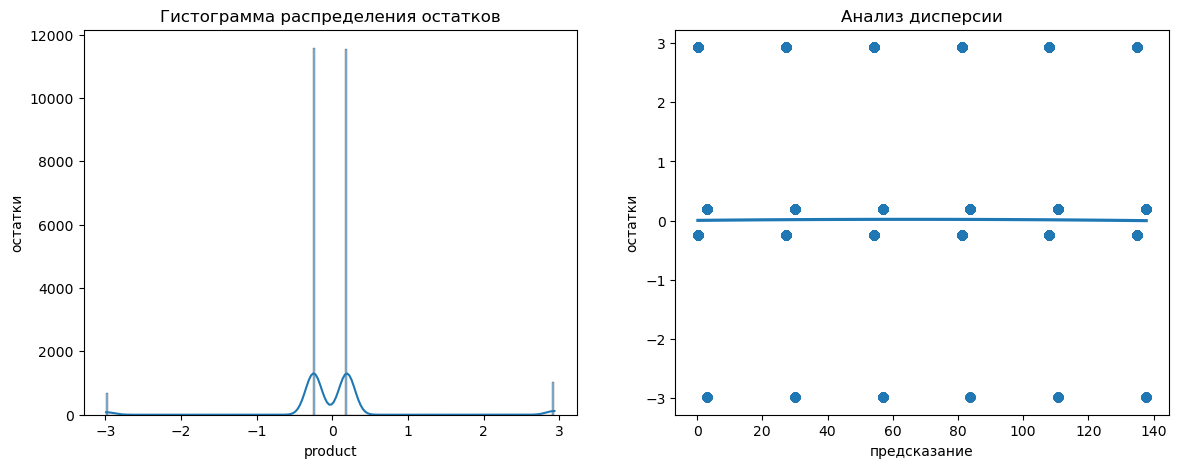

In [46]:
pred_1 = model_1.predict(preprocess_1.transform(X_valid_1))

print('Средний запас сырья:', round(y_valid_1.mean(), 2))
print('Средний запас предсказанного сырья:', round(pred_1.mean(), 2))
print('RMSE:', round(root_mean_squared_error(y_valid_1, pred_1), 2))
print('r2:', round(r2_score(y_valid_1, pred_1), 2))

residuals_plot(y_valid_1, pred_1)

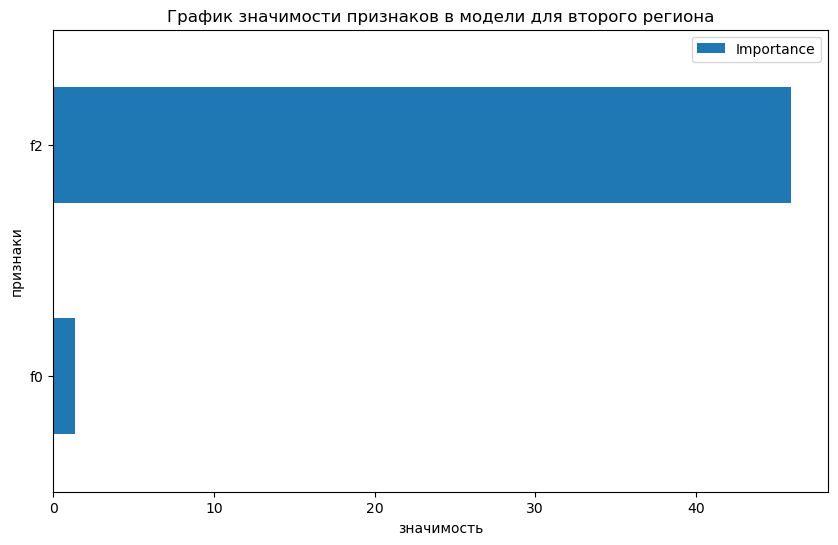

In [47]:
feature_importance = pd.DataFrame({'Feature': preprocess_1.get_feature_names_out(),
                                   'Importance': np.abs(model_1.coef_)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.title('График значимости признаков в модели для второго региона')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

Лучшая модель для второго региона имеет параметры: fit_intercept=True, positive=False. \
Признак `f2` имеет очень большую значимость в предсказательной способности модели. \
Метрики на валидационном наборе:
- RMSE: 0.8
- r2: 1.00

Модель имеет высокую точность. Остатки распределены мультимодально, маленькие пики на ±3 говорят, что очень редко модель может сильно завысить или занизить предсказание.

Средний запас сырья: 68.84 \
Средний запас предсказанного сырья: 68.83

In [48]:
grid.fit(X_train_2, y_train_2)
display(pd.DataFrame(data=grid.cv_results_).sort_values(by='rank_test_score'))

model_2 = grid.best_estimator_.named_steps['models']
preprocess_2 = grid.best_estimator_.named_steps['preprocessor']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__fit_intercept,param_models__positive,param_preprocessor__scaled,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.030212,0.002480,0.003732,0.002289,True,True,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169629,-40.065385,0.086917,1
1,0.039167,0.002624,0.001238,0.000057,True,True,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169629,-40.065385,0.086917,1
2,0.038742,0.011513,0.001781,0.000742,True,True,None,"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169629,-40.065385,0.086917,1
3,0.029679,0.003915,0.002621,0.001304,True,False,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.960254,-40.069824,-40.169091,-40.066390,0.085292,4
4,0.034815,0.001347,0.002514,0.000762,True,False,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.960254,-40.069824,-40.169091,-40.066390,0.085292,4
5,0.027182,0.002079,0.002198,0.000719,True,False,None,"{'models__fit_intercept': True, 'models__posit...",-39.960254,-40.069824,-40.169091,-40.066390,0.085292,4
7,0.030982,0.002918,0.002441,0.000841,False,True,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-40.771590,-40.886025,-41.089248,-40.915621,0.131361,7
10,0.035274,0.004958,0.002249,0.001302,False,False,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-40.771590,-40.886025,-41.089248,-40.915621,0.131361,7
8,0.033090,0.004890,0.003392,0.001909,False,True,None,"{'models__fit_intercept': False, 'models__posi...",-75.610154,-76.075488,-76.431304,-76.038982,0.336225,9
11,0.026553,0.002360,0.002164,0.000887,False,False,None,"{'models__fit_intercept': False, 'models__posi...",-75.612410,-76.074903,-76.431275,-76.039529,0.335235,10


Средний запас сырья: 94.76
Средний запас предсказанного сырья: 94.87
RMSE: 40.21
r2: 0.19


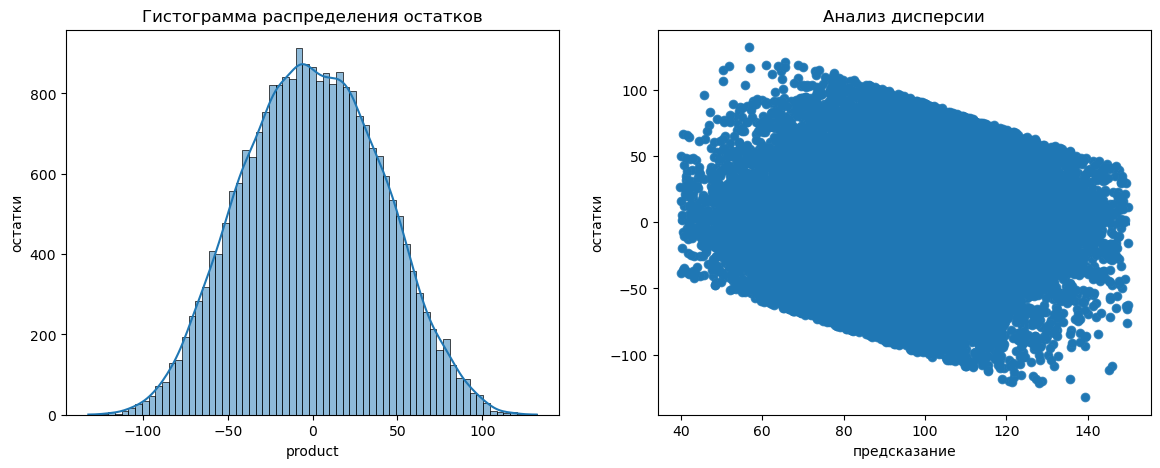

In [49]:
pred_2 = model_2.predict(preprocess_2.transform(X_valid_2))

print('Средний запас сырья:', round(y_valid_2.mean(), 2))
print('Средний запас предсказанного сырья:', round(pred_2.mean(), 2))
print('RMSE:', round(root_mean_squared_error(y_valid_2, pred_2), 2))
print('r2:', round(r2_score(y_valid_2, pred_2), 2))

residuals_plot(y_valid_2, pred_2)

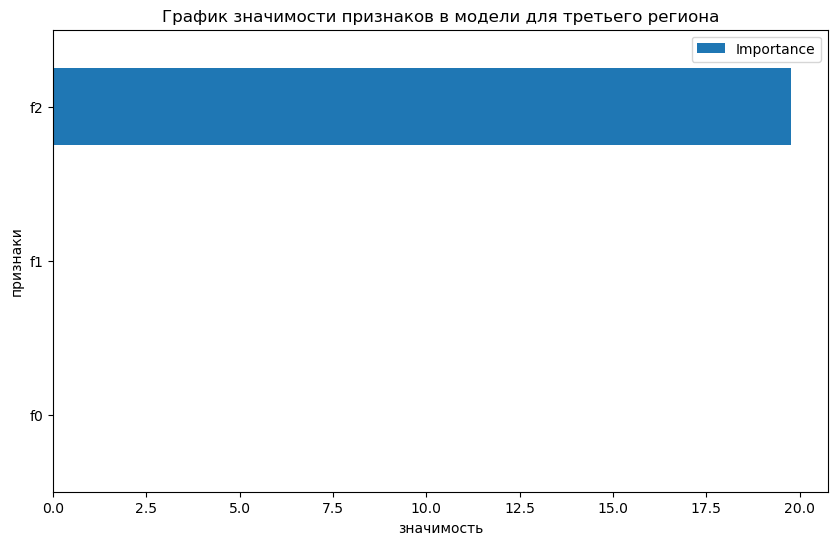

In [50]:
feature_importance = pd.DataFrame({'Feature': preprocess_2.get_feature_names_out(),
                                   'Importance': np.abs(model_2.coef_)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.title('График значимости признаков в модели для третьего региона')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

Лучшая модель для третьего региона имеет параметры: fit_intercept=True, positive=True. \
Признаки `f0` и `f1` не имеют никакого влияния на предсказательную спободность модели. Можно убрать данные признаки и облегчить модель. \
Метрики на валидационном наборе:
- RMSE: 40.21
- r2: 0.19

В 19% случаев предсказание модели ближе к истине, чем среднее значение целевого признака, что является очень плохим результатом. Модель не склонна завышать или занижать предсказания. Она не имеет систематических ошибок, а просто не объясняет данные должным образом.

Средний запас сырья: 94.76 \
Средний запас предсказанного сырья: 94.87

In [51]:
X_train_2_2, X_valid_2_2, y_train_2_2, y_valid_2_2 = train_test_split(
                                                geo_data_2.drop(['id', 'product', 'f0', 'f1'], axis=1),
                                                geo_data_2['product'],
                                                random_state=RANDOM_STATE,
                                                test_size=0.25
                                        )

In [52]:
grid.fit(X_train_2_2, y_train_2_2)
display(pd.DataFrame(data=grid.cv_results_).sort_values(by='rank_test_score'))

model_2_2 = grid.best_estimator_.named_steps['models']
preprocess_2_2 = grid.best_estimator_.named_steps['preprocessor']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__fit_intercept,param_models__positive,param_preprocessor__scaled,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017267,0.001981,0.001915,0.001471,True,True,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169593,-40.065373,0.086902,1
1,0.014630,0.003329,0.002340,0.001008,True,True,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169593,-40.065373,0.086902,1
2,0.015362,0.003908,0.002271,0.001383,True,True,None,"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169593,-40.065373,0.086902,1
3,0.015578,0.002226,0.001880,0.000654,True,False,StandardScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169593,-40.065373,0.086902,1
4,0.009065,0.000324,0.001911,0.000828,True,False,MinMaxScaler(),"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169593,-40.065373,0.086902,1
5,0.010556,0.000118,0.001101,0.000370,True,False,None,"{'models__fit_intercept': True, 'models__posit...",-39.956857,-40.069670,-40.169593,-40.065373,0.086902,1
7,0.009694,0.001394,0.001972,0.000666,False,True,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-42.117109,-42.160147,-42.472907,-42.250054,0.158557,7
10,0.014911,0.002145,0.002276,0.000900,False,False,MinMaxScaler(),"{'models__fit_intercept': False, 'models__posi...",-42.117109,-42.160147,-42.472907,-42.250054,0.158557,7
8,0.011660,0.000489,0.002003,0.000463,False,True,None,"{'models__fit_intercept': False, 'models__posi...",-75.610154,-76.075488,-76.431304,-76.038982,0.336225,9
11,0.010203,0.001740,0.001504,0.000806,False,False,None,"{'models__fit_intercept': False, 'models__posi...",-75.610154,-76.075488,-76.431304,-76.038982,0.336225,9


Средний запас сырья: 94.76
Средний запас предсказанного сырья: 94.87
RMSE: 40.21
r2: 0.19


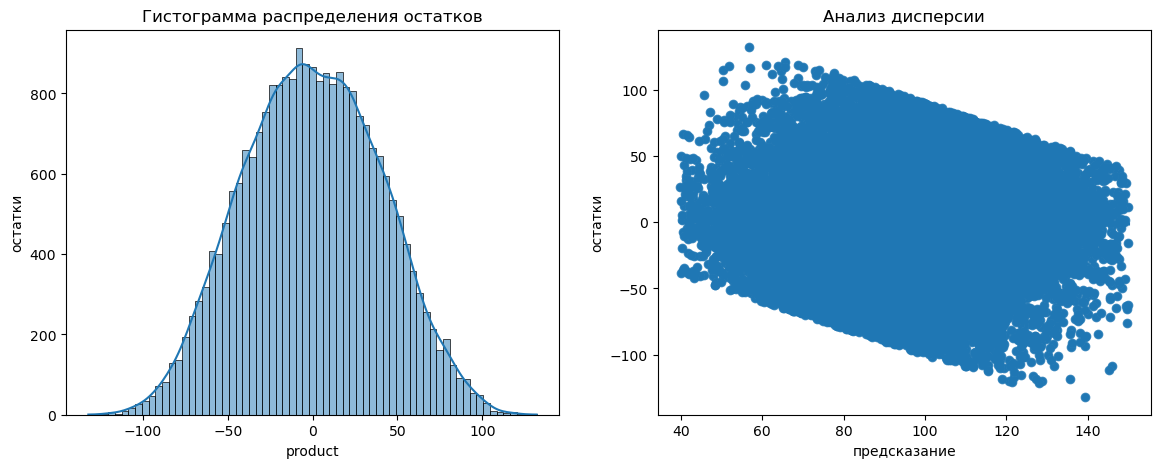

In [53]:
pred_2_2 = model_2_2.predict(preprocess_2_2.transform(X_valid_2_2))

print('Средний запас сырья:', round(y_valid_2_2.mean(), 2))
print('Средний запас предсказанного сырья:', round(pred_2_2.mean(), 2))
print('RMSE:', round(root_mean_squared_error(y_valid_2_2, pred_2_2), 2))
print('r2:', round(r2_score(y_valid_2_2, pred_2_2), 2))

residuals_plot(y_valid_2_2, pred_2_2)

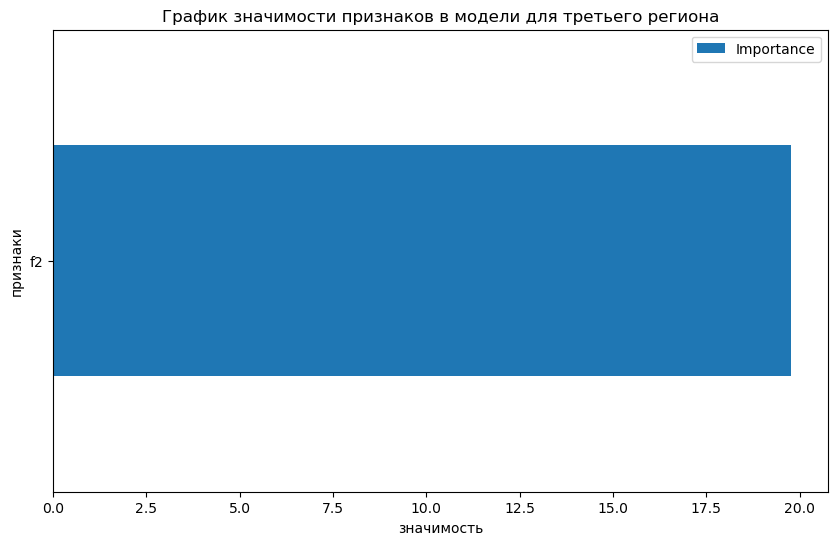

In [54]:
feature_importance = pd.DataFrame({'Feature': preprocess_2_2.get_feature_names_out(),
                                   'Importance': np.abs(model_2_2.coef_)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

plt.title('График значимости признаков в модели для третьего региона')
plt.xlabel('значимость') 
plt.ylabel('признаки') 

plt.show()

Точность модели осталась прежней, сложность была значительно уменьшена.

#### Вывод подготовки данных и обучения моделей

Данные были разделены на тренировочные и валидационные в пропорции 75/25. Используя пайплайн, возможные пропуски могут быть преобразованы, затем все признаки будут отмасштабированы. На кросс-валидации были подобраны параметры для моделей. Для первого и третьего региона модели имеют слабые предсказательные способности. Для второго региона модель имеет высокую точность, но на экстремальных значениях она может очень редко сильно ошибаться и в данном регионе максимальное значение объема запасов сильно уступает первому и третьему регионам. Сложность модели для третьего региона была значительно уменьшена за счет избавления от незначимых признаков.

### [Расчет прибыли](#task_5_plan) <a id='task_5'></a>

In [55]:
budget = 10e9 # бюджет на разработку скважин в регионе
n_well = 200 # количество скважин на разработку
income = 450e3 # доход с единицы продукта

print('Достаточный объём сырья для безубыточной разработки региона:', round(budget / income, 2))
print('Достаточный объём сырья для безубыточной разработки новой скважины:', round(budget / (n_well * income), 2))

print('Средний запас сырья в первом регионе:', round(geo_data_0['product'].mean(), 2))
print('Средний запас сырья во второй регионе:', round(geo_data_1['product'].mean(), 2))
print('Средний запас сырья в третьем регионе:', round(geo_data_2['product'].mean(), 2))

Достаточный объём сырья для безубыточной разработки региона: 22222.22
Достаточный объём сырья для безубыточной разработки новой скважины: 111.11
Средний запас сырья в первом регионе: 92.5
Средний запас сырья во второй регионе: 68.81
Средний запас сырья в третьем регионе: 94.79


Во всех регионах средний запас сырья меньше безубыточного оъбёма скважины. Необходимо в каждом из регионов находить 200 скважин с наибольшим количеством запасов сырья, которые будут не менье 22222 тыс. баррелей, чтобы не уйти в убыток.

In [56]:
# Функция расчета прибыли для выбранного региона
def get_income(arr):
    if isinstance(arr, pd.Series):
        arr = arr.to_numpy()
    return round(sum(sorted(arr, reverse=True)[:200]) * income)

In [57]:
alpha=0.025 #2.5%
N_BOOTSTRAP=1000

# бутстрап для подсчета прибыли и рисков в регионе
def income_bootstrap(y_pred):
    np.random.seed(RANDOM_STATE) # фиксируем воспроизводимость результатов
    plt.figure(figsize=(22, 6))
    
    income_boot = []
    for _ in range(N_BOOTSTRAP):
        income_boot.append(get_income(y_pred[np.random.choice(len(y_pred), size=500, replace=False)]) - budget)
        
    confidence_interval = np.quantile(income_boot, [0.025, 0.975])
    income_mean = np.mean(income_boot)
    risk_of_loss = st.norm.cdf(0, loc=income_mean, scale=np.std(income_boot))
    
    # визуализация прибыли: распределения, доверительного интервала, среднего и нуля
    axes = sns.histplot(income_boot, stat="density")
    plt.axvline(x=income_mean, color='green', linestyle='-', alpha=0.7, label=f"Наблюдаемая прибль: {income_mean:.0f}")
    
    plt.axvline(x=confidence_interval[0], color='r', linestyle='--', alpha=0.5, label=f"2.5%: {confidence_interval[0]:.0f}")
    plt.axvline(x=confidence_interval[1], color='r', linestyle='--', alpha=0.5, label=f"97.5%: {confidence_interval[1]:.0f}")
    
    plt.axvline(0, color="blue", linestyle="solid", label=f"0")
    plt.legend(fontsize=14)
    
    axes.set_ylabel('Частота', fontsize=14)
    axes.set_xlabel('Прибыль', fontsize=14)
    
    # оценка рисков
    if risk_of_loss < alpha:
        print('Вероятность убытков меньше 2.5%:', round(risk_of_loss, 3))
    else:
        print('Вероятность убытков больше 2.5%:', round(risk_of_loss, 3))

Вероятность убытков меньше 2.5%: 0.001


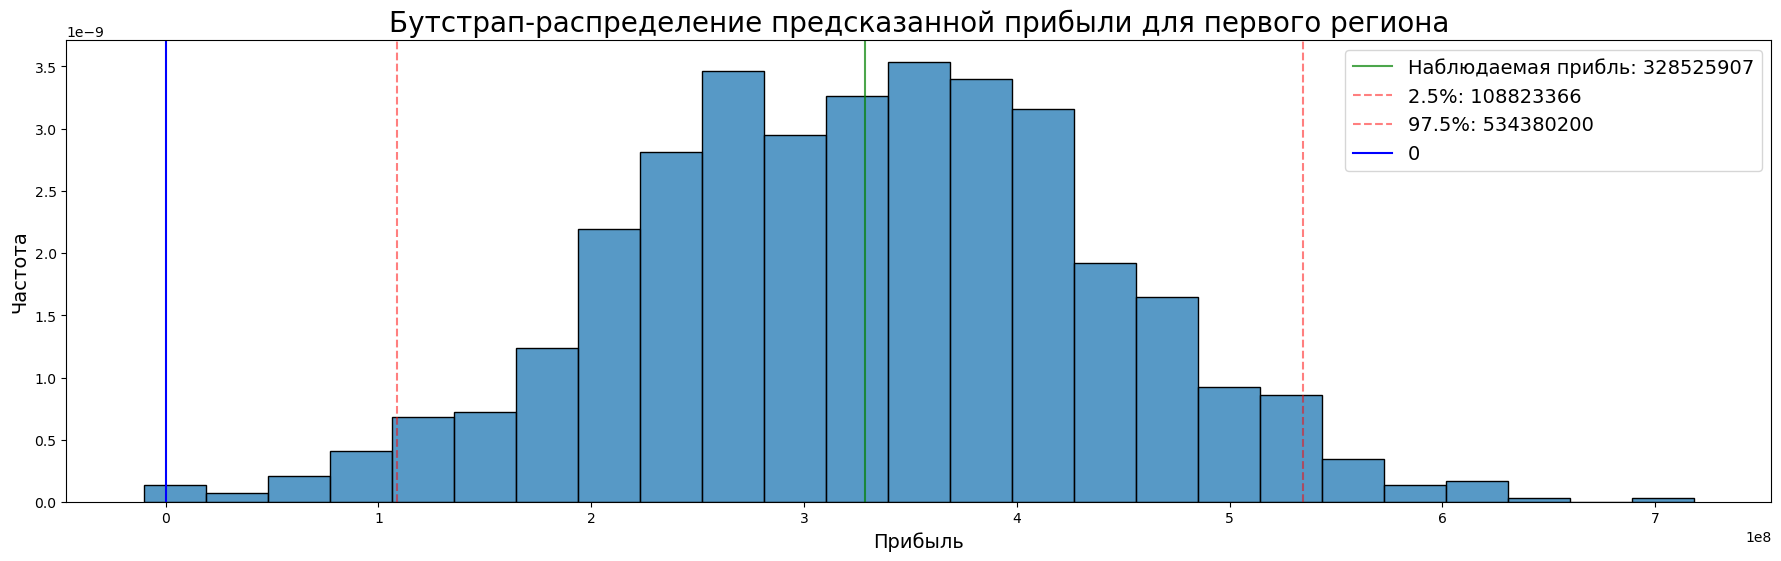

In [58]:
income_bootstrap(pred_0)
plt.title('Бутстрап-распределение предсказанной прибыли для первого региона', fontsize=20)
plt.show()

В первом регионе есть малая вероятность риска, равная 0.001, что меньше 2.5%. Модель не объясняет данные должным образом, с вероятностью 95% истиная прибыль находится между 108 млн. и 534 млн., вероятнее всего точная модель не имела бы вероятность риска более 2.5%. Наблюдаемая прибыль - 328 млн.

Вероятность убытков меньше 2.5%: 0.011


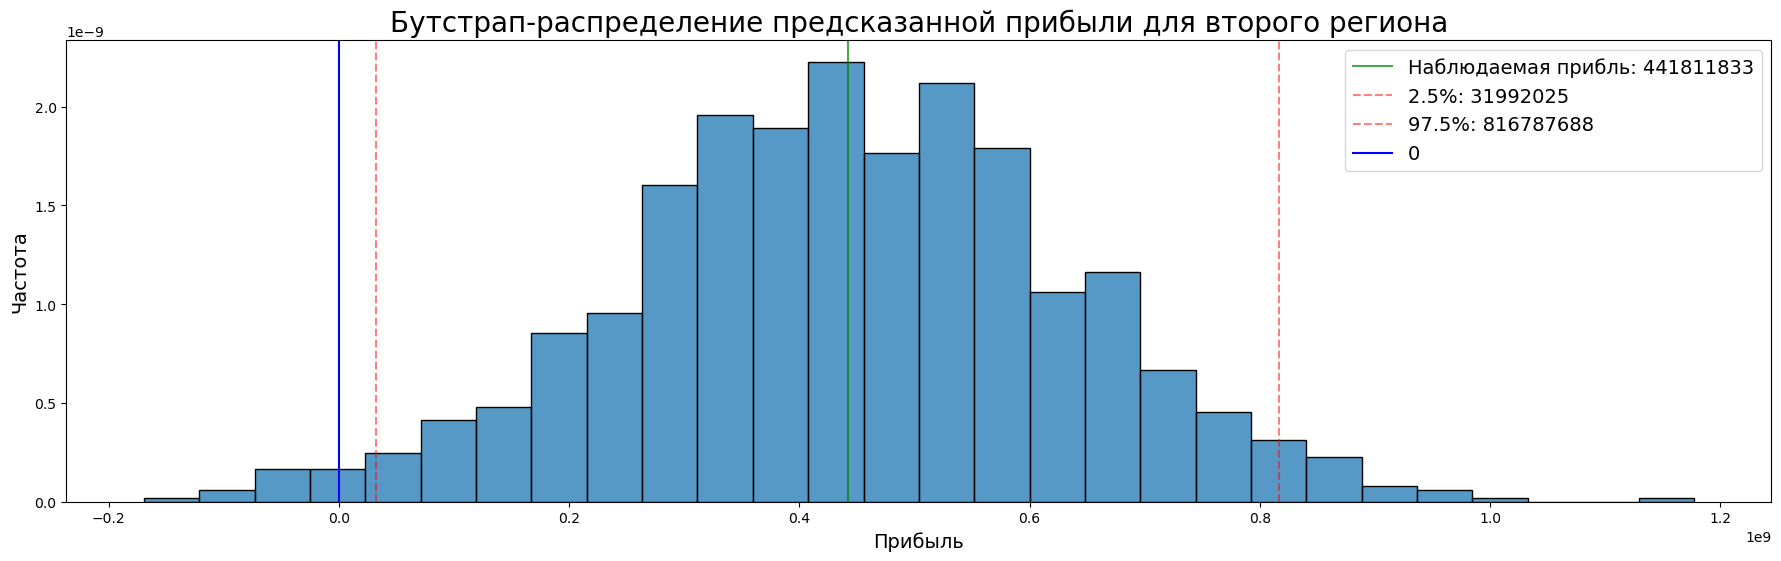

In [59]:
income_bootstrap(pred_1)
plt.title('Бутстрап-распределение предсказанной прибыли для второго региона', fontsize=20)
plt.show()

Во втором регионе есть малая доля риска, равная 0.011. Модель имеет высокую точность, доверительный интервал гласит, что с вероятностью 95% истиная прибыль находится между 32 млн. и 817 млн. - разброс возможной прибыли очень большой. Наблюдаемая прибыль - 442 млн.

Вероятность убытков меньше 2.5%: 0.002


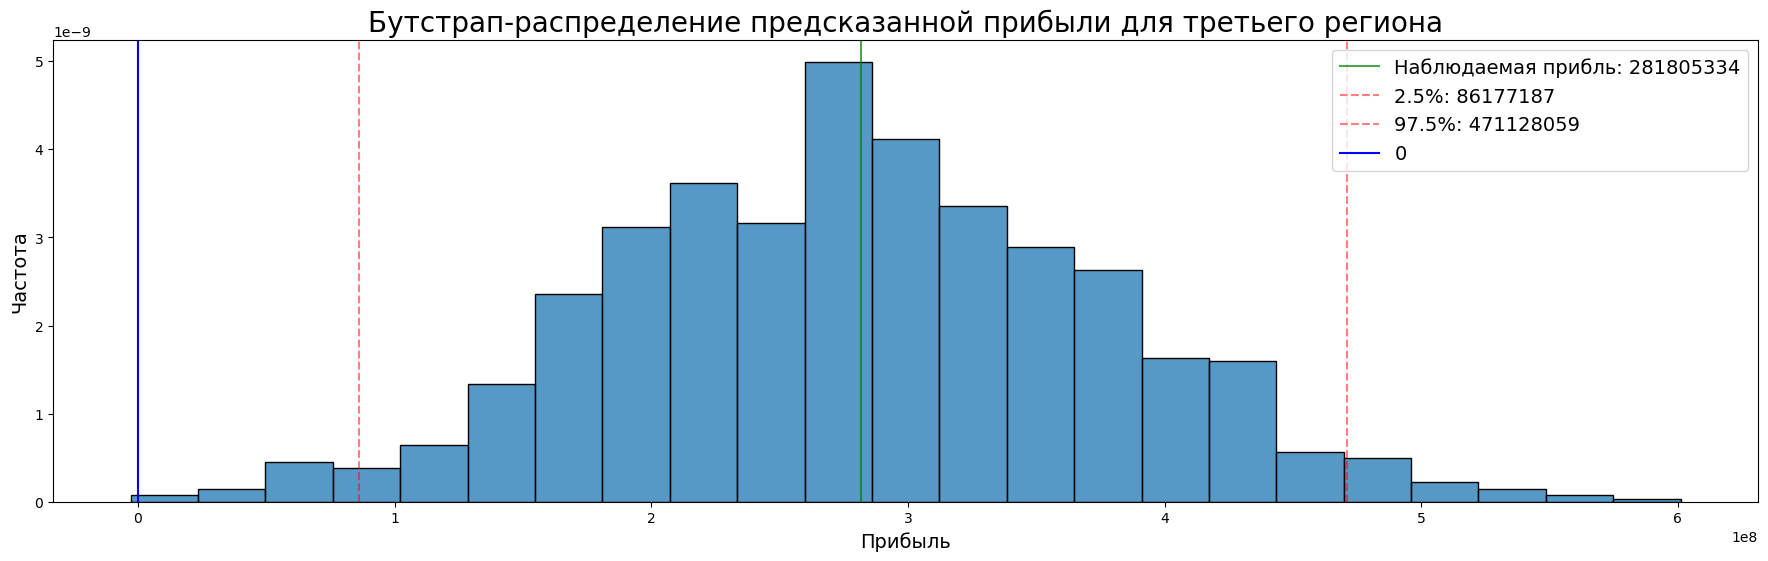

In [60]:
income_bootstrap(pred_2_2)
plt.title('Бутстрап-распределение предсказанной прибыли для третьего региона', fontsize=20)
plt.show()

В третьем регионе вероятность риска равна 0.002. Модель не объясняет данные должным образом, с вероятностью 95% истиная прибыль находится между 86 млн. и 471 млн., наблюдаемая прибыль - 281 млн.

#### Вывод расчета прибыли

Для первого и третьего регионов модель не может эффективно предсказать зависимость между входными данными и целевой переменной. Пологаться на результаты данных моделей критически опасно. Рекомендуется второй регион для разработки скважин, хоть и разброс возможной прибыли очень велик, но модель имеет высокую точность, ей можно доверять.

### [Вывод работы](#result_plan) <a id='result'></a>

- ETL/EDA:

    - Данные во всех регионах являются синтетическими. Все датасеты не имеют пропусков, неправильных типов данных. Выбросы в признаках удалены фильтрацией по 1.5 IQR.

    1. Регион **`geo_data_0`**
        - Признаки `f0`, `f1` переведены в категориальные по минимумам экстремумов.
        - Признак `f2` распределен по Гауссу
        - Корреляционный анализ:
            - Признаки `f0` (0.19), `f1` (0.26) не имеют линейной связи. 
            - Признак `f2` (0.42) имеет очень слабую положительную связь.


    2. Регион **`geo_data_1`**
        - Запасы имеют равномерное распределение.
        - 12 уникальных категорий, максимальный запас — 138 тыс. баррелей, что меньше двух других регионов
        - Признаки `f0`, `f2` переведены в категориальные по минимумам экстремумов.
        - Признак `f1` не влияет на уровень запасов.
        - Корреляционный анализ:
            - Признак `f2` (1.00) имеет сильную прямую положительную связь с целевым. 
            - Признаки `f0` (0.87) и `f1` (0.19) не имеют линейной связи с `product`.


    3. Регион **`geo_data_2`**
        - Входные признаки распределены по Гауссу
        - Целевой признак имеет схожее распределение с целевым для первого региона
        - Корреляционный анализ:
            - Признак `f2` (0.44) имеет очень слабую положительную связь.
            - Признаки `f0` (0.23) и `f1` (0.23) не имеют явной связи с `product`.

- Подготовка данных и обучение модели:

    - Данные каждого региона были поделены на тренировочные и валидационные в пропорции 75/25. Создан пайплайн с предобработкой пропусков и масштабированием признаков.

    1. Регион **`geo_data_0`**
        - Лучшая модель имеет параметры: fit_intercept=True, positive=False.
        - Признак `f2` имеет наибольшую значимость в предсказательной способности модели.
        - Метрики на валидационном наборе:
            - RMSE: 37.77
            - r2: 0.27
        - **Модель не объясняет данные должным образом.** 
        - Средний запас сырья: 92.41 
        - Средний запас предсказанного сырья: 92.43


    2. Регион **`geo_data_1`**
        - Лучшая модель имеет параметры: fit_intercept=True, positive=False.
        - Признак `f2` имеет очень большую значимость в предсказательной способности модели.
        - Метрики на валидационном наборе:
            - RMSE: 0.8
            - r2: 1.00
        - **Модель имеет высокую точность.** Но может очень редко сильно завысить или занизить предсказание.
        - Средний запас сырья: 68.84 
        - Средний запас предсказанного сырья: 68.83


    3. Регион **`geo_data_2`**
        - Лучшая модель имеет параметры: fit_intercept=True, positive=True. 
        - Признаки `f0` и `f1` были убраны, они не имеют никакого значения для модели.
        - Метрики на валидационном наборе:
            - RMSE: 40.21
            - r2: 0.19
        - **Модель не объясняет данные должным образом.** 
        - Средний запас сырья: 94.76 
        - Средний запас предсказанного сырья: 94.87

Во всех регионах средний запас сырья меньше безубыточного оъбёма скважины. Необходимо в каждом из регионов находить 200 скважин с наибольшим количеством запасов сырья, которые будут не менье 22222 тыс. баррелей, чтобы не уйти в убыток. Для первого и третьего регионов модель не может эффективно предсказать зависимость между входными данными и целевой переменной. Пологаться на результаты данных моделей критически опасно. **Рекомендуется второй регион** для разработки скважин, хоть и разброс возможной прибыли очень велик (32 млн., 817 млн), но модель имеет высокую точность, ей можно доверять. Наблюдаемая прибыль - 442 млн., доля риска равна 0.011. Также можно попробовать использовать другие модели, так как для двух регионов линейная регрессия не объясняет данные должным образом.